# Data prep and epoching

In [47]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfreqz
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle
%matplotlib inline

The butter_bandpass_filter function is designed to clean up Brain-Computer Interface (BCI) data by filtering out unwanted frequencies, allowing only the frequencies of interest to pass through.

**Sampling Frequency (fs)**: BCI data is collected at a certain rate, known as the sampling frequency. This function uses that rate to understand the time intervals of your data.

**Nyquist Frequency:** This is half of the sampling frequency and is important for digital signal processing. It helps in normalizing the cutoff frequencies.

In [48]:
fs = 200.0     # 200 Hz sampling rate
lowcut = 1.0   # 0.1 Hz is the lowest frequency we will pass
highcut = 40.0 # 40 Hz is the highest frequency we will pass.


def butter_bandpass_filter(raw_data, fs, lowcut = 1.0, highcut = 40.0, order = 5):
  nyq = 0.5 * fs
  low = lowcut/nyq
  high = highcut/nyq
  sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
  filted_data = sosfiltfilt(sos, raw_data)
  return filted_data

**Epoch**: An epoch is a segment of data that typically corresponds to a specific event or stimulus in BCI experiments. In this case, the epoch starts at the stimulus (0 ms) and ends 700 ms after the stimulus.

**Baseline**: The baseline is a reference period used to normalize the data. It starts at the stimulus (0 ms) and ends 100 ms after the stimulus.

epoch_len is the number of data points (samples) that correspond to the epoch duration. For example, if fs (sampling frequency) is 1000 Hz, then epoch_len would be 700 ms * (1000 samples/second) / 1000 = 700 samples.

This means the segment of data from the stimulus to 700 ms after the stimulus will have 700 samples if the sampling rate is 1000 Hz. This is crucial for processing BCI data because you need to know how many data points to extract and analyze for each epoch related to a stimulus.

In [49]:
epoch_s = 0
epoch_e = 700
bl_s = 0
bl_e = 100


# number of mark per epoch
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

In [50]:
train_subj_num = 16
test_subj_num = 10
stimulus_per_subj = 340
trial_per_subj = 5

channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
    'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
    'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'POz', 'P08', 'O1', 'O2']

In [51]:
import pandas as pd
train_labels = pd.read_csv("TrainLabels.csv")
sample_train_data = pd.read_csv("train\Data_S02_Sess01.csv")

In [52]:
train_labels

IdFeedBack  Prediction
0     S02_Sess01_FB001           1
1     S02_Sess01_FB002           1
2     S02_Sess01_FB003           0
3     S02_Sess01_FB004           0
4     S02_Sess01_FB005           1
...                ...         ...
5435  S26_Sess05_FB096           1
5436  S26_Sess05_FB097           0
5437  S26_Sess05_FB098           0
5438  S26_Sess05_FB099           0
5439  S26_Sess05_FB100           1

[5440 rows x 2 columns]

In [53]:
sample_train_data

Time         Fp1          Fp2         AF7         AF3         AF4   
0         0.000  509.630351   609.688545  522.032153  454.102593  309.486489  \
1         0.005  864.521388  1038.483761  917.023604  775.970207  576.123392   
2         0.010  754.576625   904.117869  803.235608  678.039830  489.573235   
3         0.015  801.593761   957.870867  834.026569  716.254450  519.006819   
4         0.020  769.054899   920.060832  811.596932  692.750986  494.315305   
...         ...         ...          ...         ...         ...         ...   
131996  659.980  326.493877   148.619853  367.120885  329.607132  568.760051   
131997  659.985  299.398029   122.348935  317.862613  299.081994  540.210149   
131998  659.990  313.987327   143.185940  352.162704  321.971403  551.396419   
131999  659.995  308.194641   121.836127  323.251844  313.754887  575.047001   
132000  660.000  236.894562   118.063306  273.854465  243.895105  416.279695   

               AF8          F7          F5          F3  ...          P4   
0       524.804335  484.333383  587.340998  469.651564  ...  295.834834  \
1       934.962455  833.427809  996.070640  823.715523  ...  528.713692   
2       803.064230  706.392172  868.996293  717.565698  ...  459.066586   
3       860.058239  769.518284  921.777695  756.664761  ...  487.899954   
4       817.206918  727.500302  892.004312  729.239924  ...  464.032652   
...            ...         ...         ...         ...  ...         ...   
131996  228.081535  386.342230  193.539354  263.262863  ...  497.935681   
131997  183.619873  354.533814  148.285289  208.522216  ...  483.786225   
131998  219.448645  345.700353  196.750843  253.721728  ...  482.381296   
131999  202.242791  358.987420  165.629556  231.005230  ...  511.892613   
132000  188.173085  270.812314  167.005916  215.650455  ...  353.931780   

                P6          P8         PO7         POz          P08   
0       485.530586  411.161892  448.726097   99.151239   613.529369  \
1       894.541770  735.827300  780.487458  239.407648  1067.349342   
2       870.217213  691.971456  689.656321  255.876323   933.617965   
3       905.564172  723.595463  723.944898  247.990115   992.180045   
4       769.258159  642.962959  687.852792  179.835749   949.832471   
...            ...         ...         ...         ...          ...   
131996  136.897186  194.816484  235.516599  698.470304   115.904670   
131997   87.994431  158.168639  220.717339  681.475238    69.722673   
131998  130.181271  228.417928  229.943069  718.838360   110.441383   
131999  103.343795  229.027509  233.729526  782.742133    85.836597   
132000  122.418483  154.473702  177.953948  500.095611   109.008917   

                O1          O2          EOG  FeedBackEvent  
0       428.286969  378.933590  -906.668876              0  
1       782.319229  711.286079 -1484.107119              0  
2       679.366071  699.014004 -1313.435186              0  
3       713.405603  714.734949 -1391.966973              0  
4       680.906506  607.057329 -1347.494166              0  
...            ...         ...          ...            ...  
131996  346.770258  -22.426859 -1179.103975              0  
131997  304.952629  -71.490262 -1245.844338              0  
131998  325.000921   62.368775 -1150.955909              0  
131999  327.645835   38.482607 -1304.594442              0  
132000  269.794326   18.927431  -805.816250              0  

[132001 rows x 59 columns]

**Reshape the Arrays:**

In [54]:
train_list_arr = np.array(sorted(listdir('train')))
train_list_np = np.reshape(
    train_list_arr, (train_subj_num, trial_per_subj))
test_list_arr = np.array(sorted(listdir('test')))
test_list_np = np.reshape(
    test_list_arr, (test_subj_num, trial_per_subj))
print(train_list_np.shape, test_list_np.shape)

train_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
print(train_data_list.shape, test_data_list.shape)

(16, 5) (10, 5)
(0, 340, 56, 140) (0, 340, 56, 140)


This function generate_epoch processes raw EEG data to extract epochs around stimulus events,

    #channels ([String]): array of channels to epoch
    #fs (float): sampling rate
    #eeg_filter (function): the filter you want to apply to raw eeg data
    #stimulus_times ([float], optional): The time points that stimulus occur
    #baseline (boolean, optional): whether you want to apply baseline correction after epoching
    #epoch_s (int, optional): epoch starting time relative to stmulus in miliseconds
    #epoch_e (int, optional): epoch ending time relative to stmulus in miliseconds
    #bl_s (int, optional): baseline starting time relative to stmulus in miliseconds
    #bl_e (int, optional): baseline ending time relative to stmulus in miliseconds

    #rtype (3d-nparray): epoched data with dimension (stimulus_per_trial, number_of_channels, number_of_time_points)

In [55]:
def generate_epoch(file_path, channels, fs, eeg_filter, stimulus_times=None, baseline=True,  epoch_s=0, epoch_e=700, bl_s=0, bl_e=100):
    # Generating epoch given csv file so that it should contain 'Time' column that represents timepoints, and the time should start from 0.
    # If your csv file does not have FeedBackEvent indicating the stimulus, you must pass stumulus_times.
    # Here we used a butter bandpass filter

    train_data = pd.read_csv(file_path)

    train_data.loc[:, 'Time'] = train_data.loc[:, 'Time']*1000
    raw_eeg = train_data[channels].values.T

    time_df = train_data['Time'].values
    train_data['index'] = train_data.index.values
    if stimulus_times is None:
        mark_indices = np.asarray(
            train_data[train_data['FeedBackEvent'] == 1].index).flatten()
    else:
        mark_indices = np.round(np.asarray(
            stimulus_times).flatten() * fs).astype(int)

    # We define the bounds of our epoch as well as our baseline

    # index in epoch_df where our baseline begins
    b_s = int((abs(epoch_s) + bl_s) * (fs / 1000))
    # index in epoch_df where our baseline ends
    b_e = int((abs(epoch_s) + bl_e) * (fs / 1000))

    # Let's calculate the length our epoch with our given sampling rate
    epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

    # The number of indices before marker we want
    e_s = int((epoch_s * (fs / 1000)))
    # The number of indices after marker we want
    e_e = int((epoch_e * (fs / 1000)))

    # Epoch the data
    final_epoch = np.empty((mark_indices.shape[0], epoch_len, 0), float)
    for channel in channels:
        epoch = np.zeros(shape=(int(mark_indices.shape[0]), epoch_len))
        raw_eeg = train_data[channel].values

        clean_eeg = eeg_filter(raw_eeg, fs, lowcut, highcut, 5)

        for i, mark_idx in enumerate(mark_indices):
            # grab the appropriate samples around the stimulus onset
            epoch[i, :] = clean_eeg[mark_idx + e_s: mark_idx + e_e]

        # Baseline correction
        if baseline:
            for i in range(0, int(epoch.shape[0])):
                epoch[i, :] = epoch[i, :] - np.mean(epoch[i, b_s:b_e])

        # stack epoch of each channel
        final_epoch = np.dstack((final_epoch, epoch))
    final_epoch = np.swapaxes(final_epoch, 1, 2)
    return final_epoch


This code snippet is designed to preprocess and save EEG data for a P300 speller system. Specifically, it extracts epochs around stimulus events for both training and testing datasets, applies a bandpass filter, performs baseline correction, and saves the processed data for further analysis.

In [56]:
if not isfile("train_data.npy"):
    for training_participant_id in range(train_subj_num):
        subject_dir_list = train_list_np[training_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('train/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        train_data_list = np.vstack((train_data_list, subject_epoch))

    print('Epoched training data shape: ' + str(train_data_list.shape))

    for testing_participant_id in range(test_subj_num):
        subject_dir_list = test_list_np[testing_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('test/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        test_data_list = np.vstack((test_data_list, subject_epoch))

    print('Epoched testing data shape: ' + str(test_data_list.shape))

    np.save('train_data.npy', train_data_list)
    np.save('test_data.npy', test_data_list)

In [57]:
train_data_list = np.load('train_data.npy')
test_data_list = np.load('test_data.npy')
print('Epoched training data shape: ' + str(train_data_list.shape))
print('Epoched testing data shape: ' + str(test_data_list.shape))

Epoched training data shape: (16, 340, 56, 140)
Epoched testing data shape: (10, 340, 56, 140)


# ERP

In [13]:
import numpy as np
import matplotlib.pyplot as plt

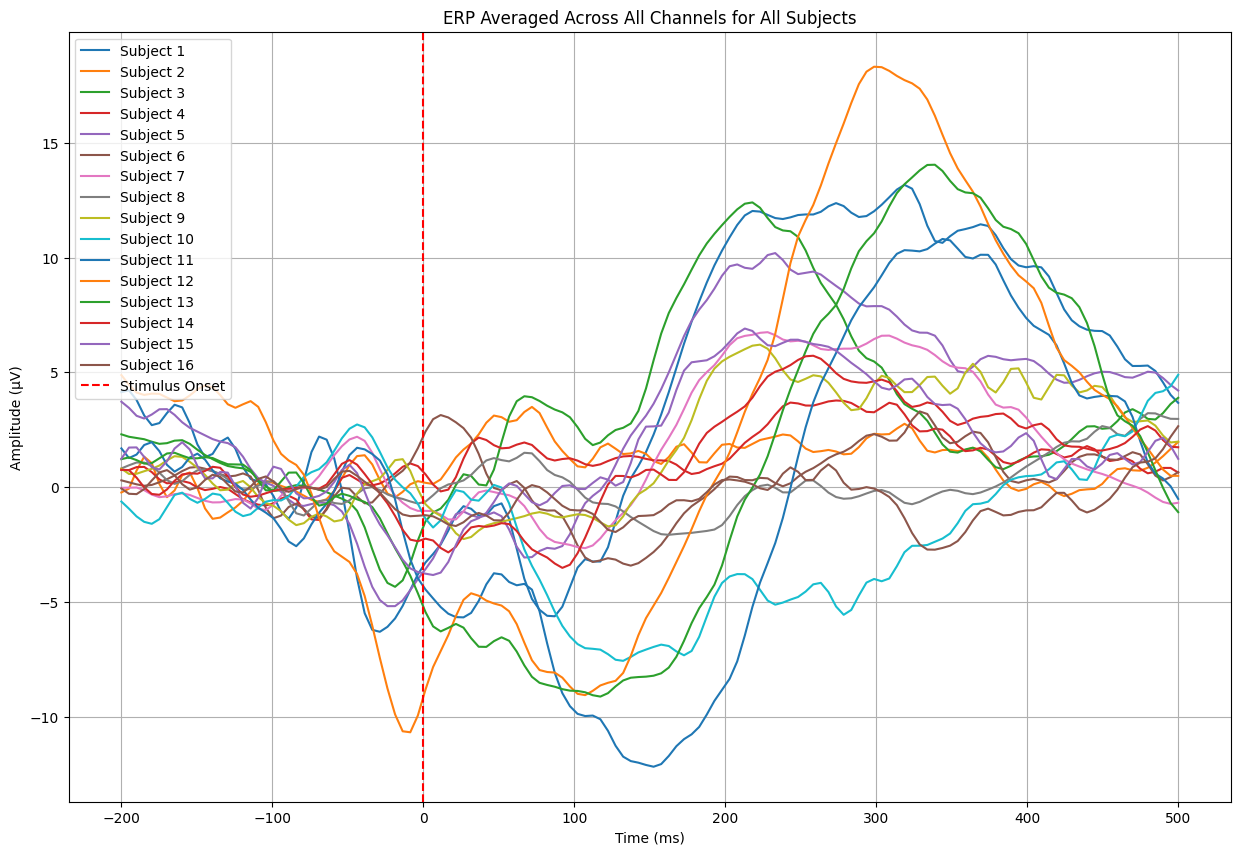

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming time is already defined
# If not, define it according to your sampling rate and epoch length
# For example, if your sampling rate is 256 Hz and each epoch is 1 second long:
time = np.linspace(-200, 500, 140)  # Adjust according to your time window

# Define the baseline period (e.g., -200 ms to 0 ms)
baseline_start = -200  # in ms
baseline_end = 0      # in ms

# Convert baseline period to indices
baseline_indices = np.where((time >= baseline_start) & (time <= baseline_end))[0]

plt.figure(figsize=(15, 10))
for subject_id in range(train_data_list.shape[0]):
    epochs = train_data_list[subject_id]

    # Average the signal across all channels for each epoch
    average_epochs = np.mean(epochs, axis=1)

    # Perform baseline correction
    baseline_values = np.mean(average_epochs[:, baseline_indices], axis=1)
    baseline_corrected_epochs = average_epochs - baseline_values[:, np.newaxis]

    # Calculate the ERP by averaging across all epochs
    erp = np.mean(baseline_corrected_epochs, axis=0)

    # Plot ERP for the current subject
    plt.plot(time, erp, label=f'Subject {subject_id + 1}')

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('ERP Averaged Across All Channels for All Subjects')
plt.axvline(x=0, color='r', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.grid(True)
plt.show()


# MNE

In [15]:
!pip install mne
import mne


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.


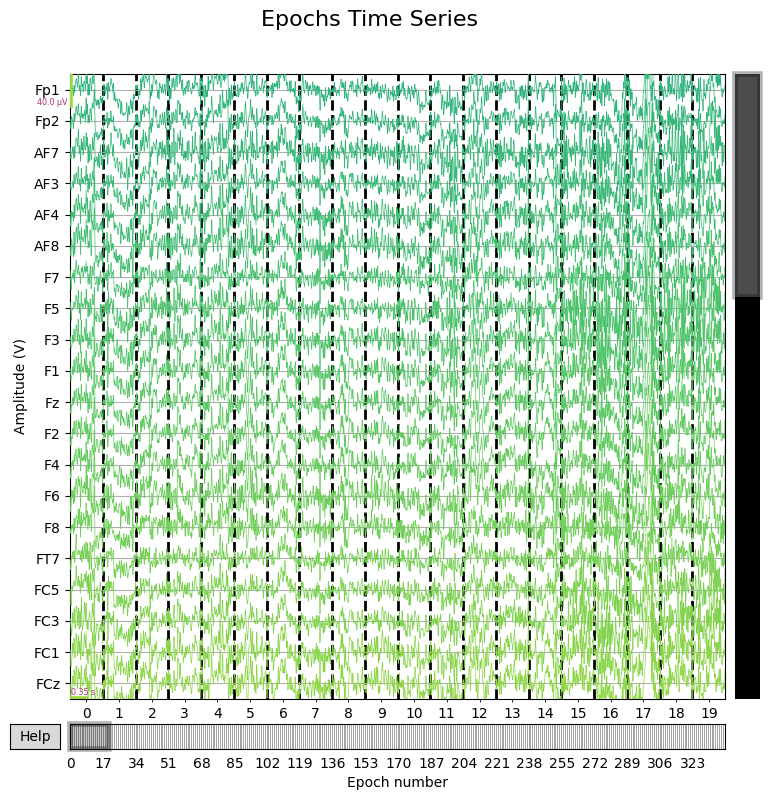

In [16]:
train_data_list = np.load('train_data.npy')

# Assuming train_data_list is of shape (subjects, epochs, channels, times)
subject_id = 0
data = train_data_list[subject_id]  # Shape: (epochs, channels, times)

# Define the sampling rate
sampling_rate = 200  # in Hz

# Create info structure
ch_names = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
            'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
            'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
            'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
            'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
            'PO7', 'POz', 'PO8', 'O1', 'O2']
ch_types = ['eeg'] * len(ch_names)

info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)
info.set_montage('standard_1020')
# Convert data from microvolts to volts
epochs_data = data / 1e6

# Create events array, assuming each epoch is an event
events = np.array([[i, 0, 1] for i in range(epochs_data.shape[0])])

# Create MNE Epochs object
epochs = mne.EpochsArray(epochs_data, info, events)

# Plot the epochs as time series
fig = epochs.plot(show=False)  # Get the figure object

# Customize the plot
fig.subplots_adjust(top=0.9)  # Adjust the top margin to make room for the title
fig.suptitle('Epochs Time Series', fontsize=16)  # Add a title

# Customize colors
ax = fig.get_axes()[0]  # Get the first (and only) axes object
lines = ax.get_lines()
colors = plt.cm.viridis(np.linspace(0.65, 0.85, len(lines)))

for line, color in zip(lines, colors):
    line.set_color(color)

# Add grid and labels
ax.grid(True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (V)')

# Show the plot
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


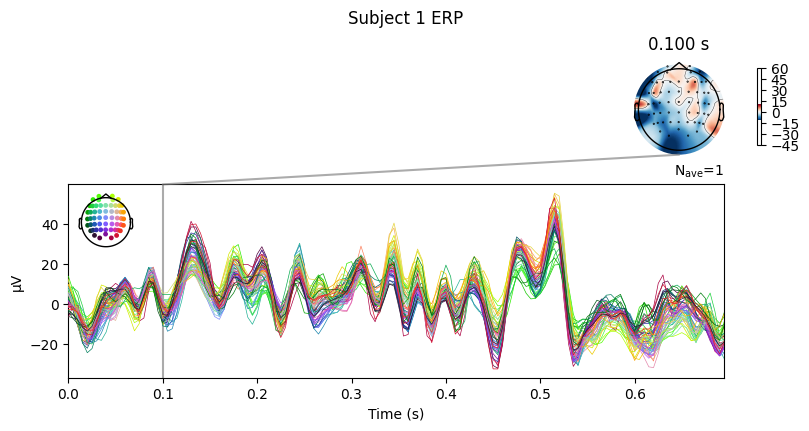

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


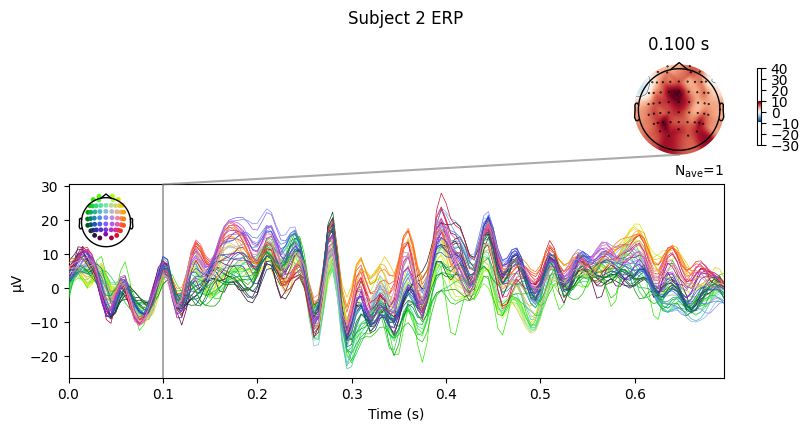

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


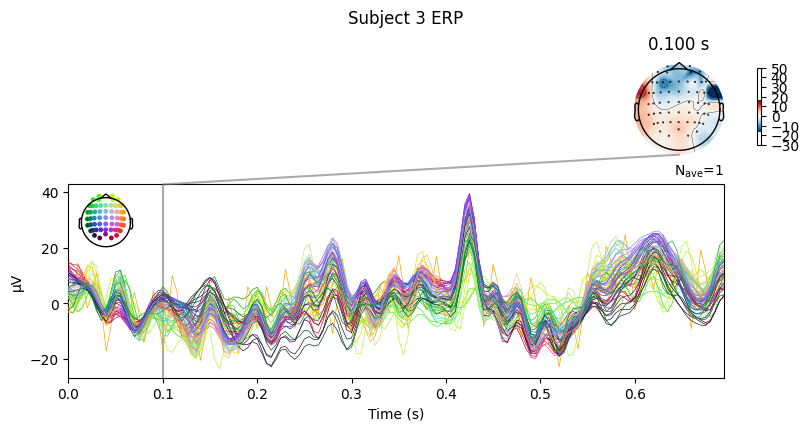

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


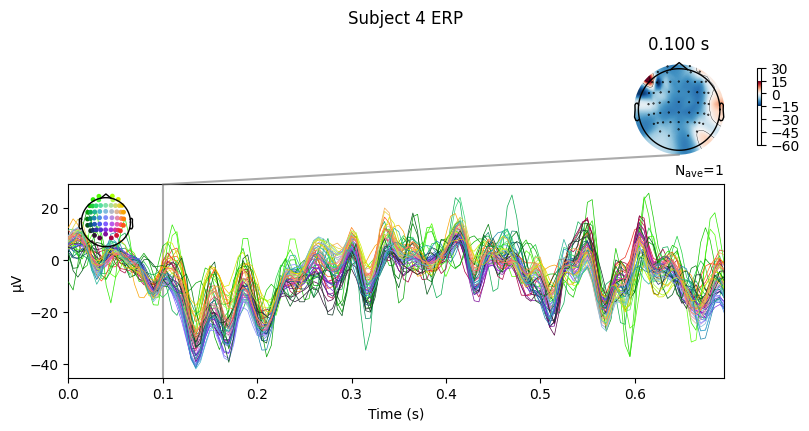

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


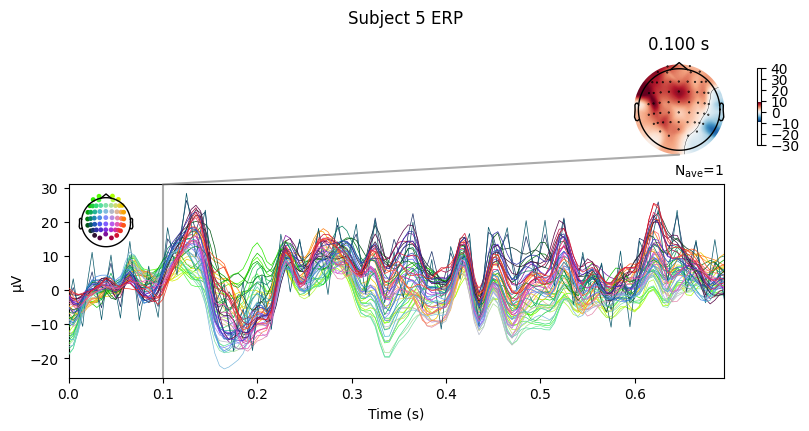

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


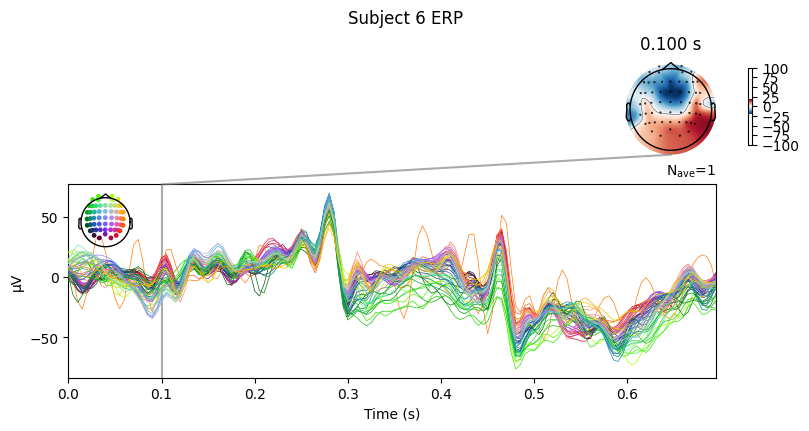

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


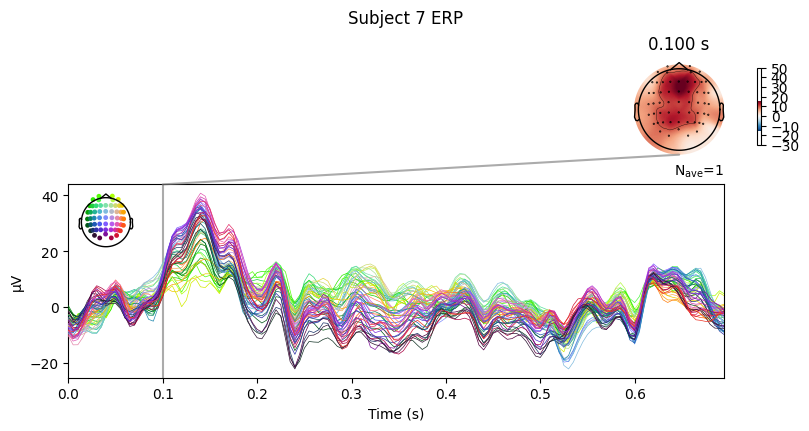

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


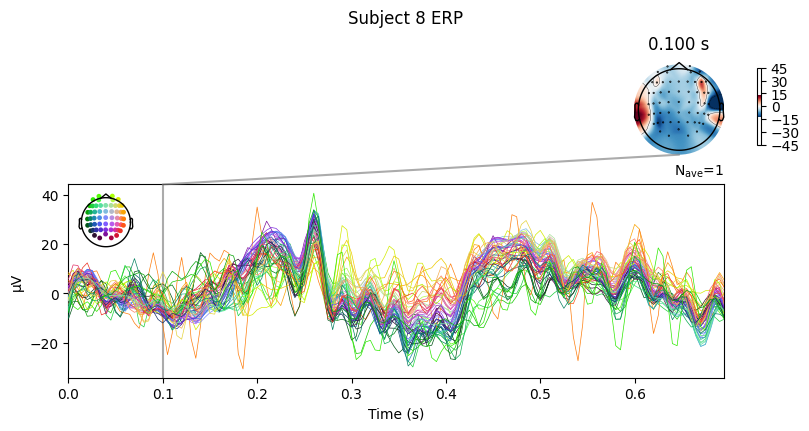

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


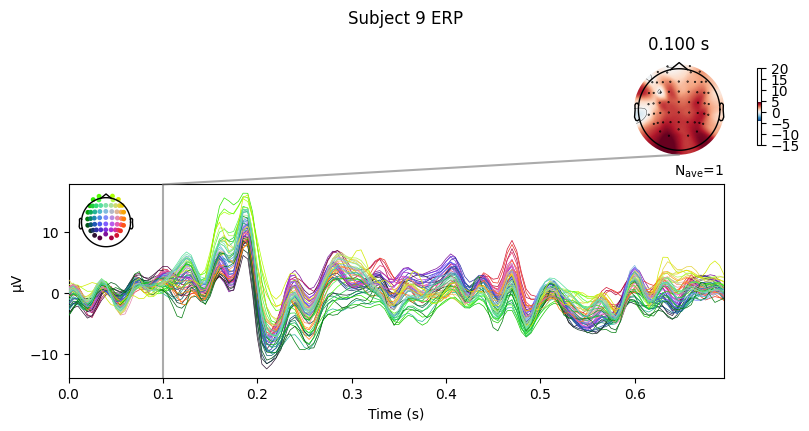

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


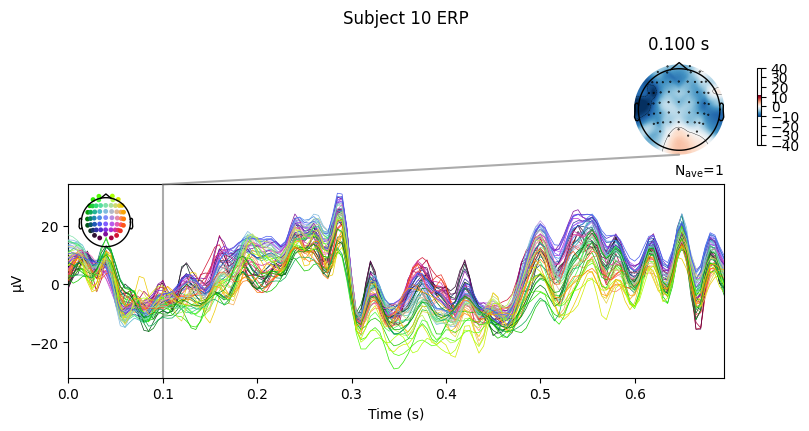

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


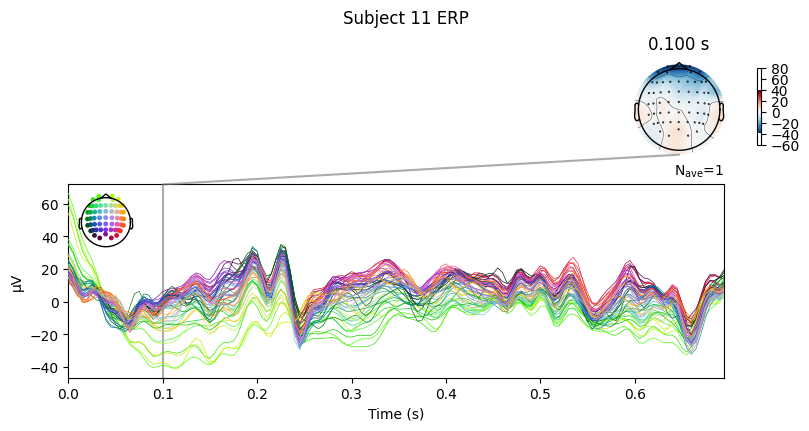

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


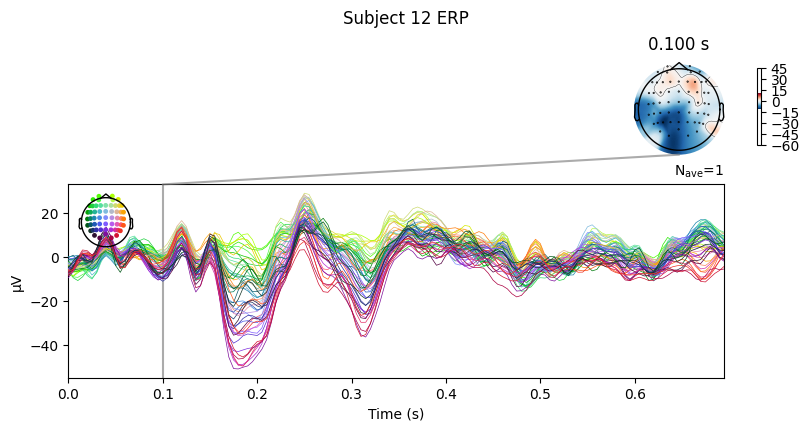

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


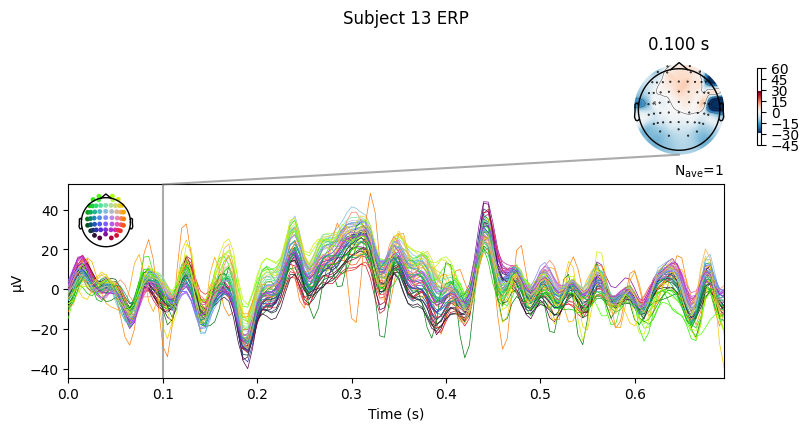

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


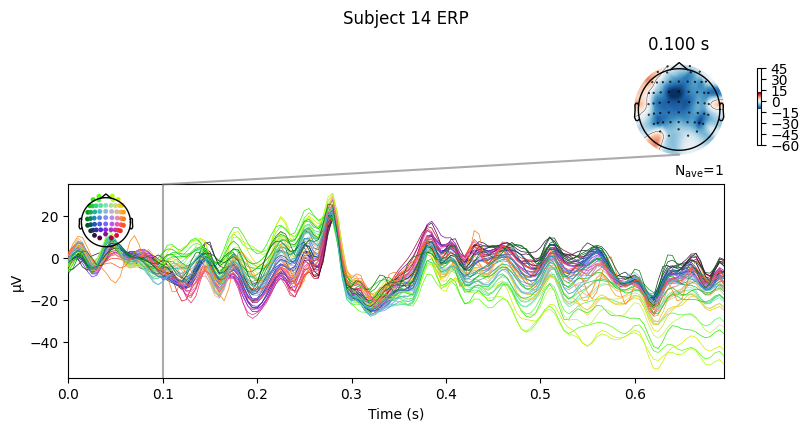

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


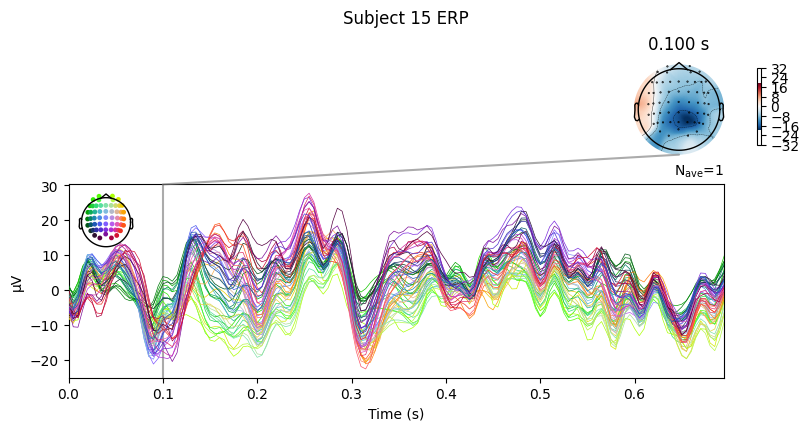

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


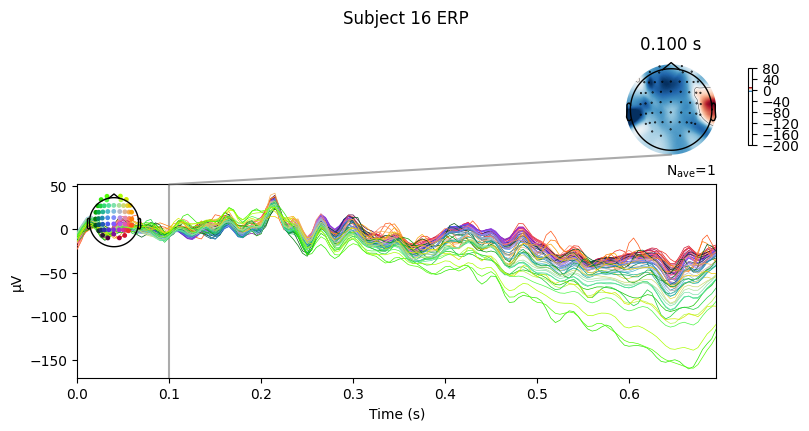

In [17]:
train_data_list = np.load('train_data.npy')

# Assuming train_data_list is of shape (subjects, epochs, channels, times)
for subject_id in range(train_data_list.shape[0]):
    data = train_data_list[subject_id]  # Shape: (epochs, channels, times)

    # Define the sampling rate
    sampling_rate = 200  # in Hz

    # Create info structure
    ch_names = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
                'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
                'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
                'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
                'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
                'PO7', 'POz', 'PO8', 'O1', 'O2']
    ch_types = ['eeg'] * len(ch_names)

    info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)
    info.set_montage('standard_1020')
    # Convert data from microvolts to volts
    epochs_data = data / 1e6

    # Create events array, assuming each epoch is an event
    events = np.array([[i, 0, 1] for i in range(epochs_data.shape[0])])

    # Create MNE Epochs object
    epochs = mne.EpochsArray(epochs_data, info, events)
        # Compute ERP (average across epochs) for the current subject
    erp = epochs[0].average()

    # Plot ERP for the current subject
    fig = erp.plot_joint(times=[0.1], title=f'Subject {subject_id + 1} ERP')

    # Customize plot if needed
    fig.axes[0].set_ylim(-10, 10)  # Example: Set ylim for the plot

    # Show plot
    plt.show()

##Plotting the power spectrum of Epochs

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\Aditya Kumar\AppData\Local\Temp\ipykernel_4416\2092758398.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.plot_psd(fmin=0.1, fmax=40.0, ax=ax)
c:\Users\Aditya Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


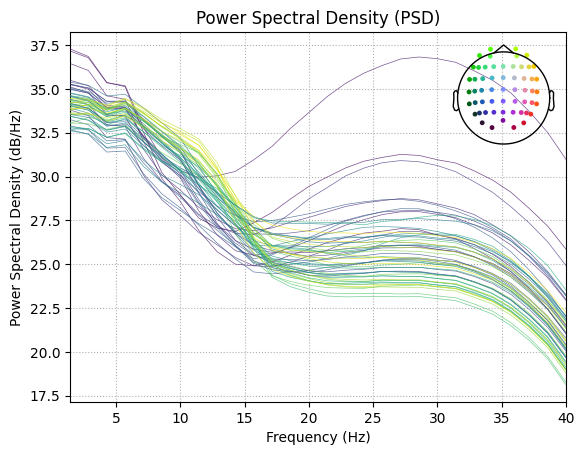

In [ ]:
fig, ax = plt.subplots()
epochs.plot_psd(fmin=0.1, fmax=40.0, ax=ax)

# Customize the colors
lines = ax.get_lines()
colors = plt.cm.viridis(np.linspace(0, 1, len(lines)))

for line, color in zip(lines, colors):

# Add grid and labels
ax.grid(True)
ax.set_title('Power Spectral Density (PSD)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dB/Hz)')

# Show the plot
plt.show()

##Image Map
A convenient way to visualize many epochs simultaneously is to plot them as an image map, with each row of pixels in the image representing a single epoch, the horizontal axis representing time, and each pixel’s color representing the signal value at that time sample for that epoch.

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


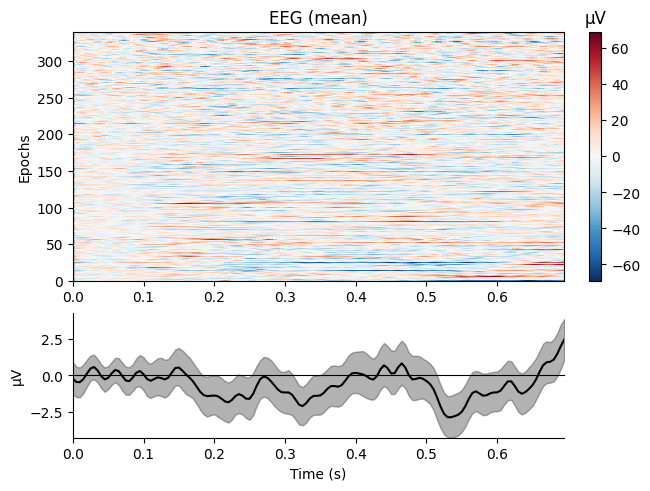

[<Figure size 640x480 with 3 Axes>]

In [19]:
epochs.plot_image(combine='mean')

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated


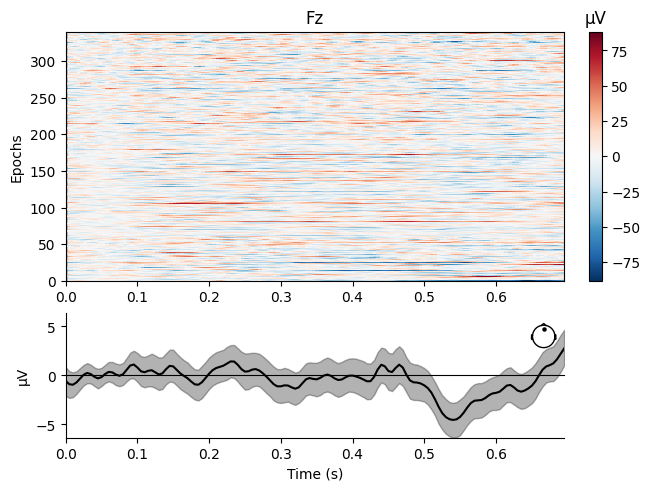

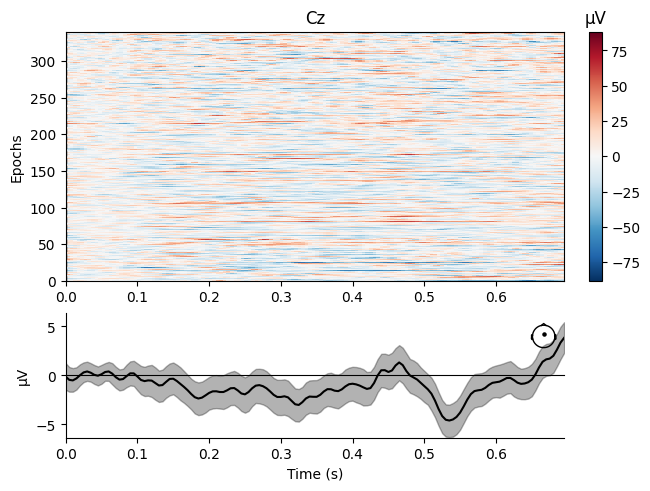

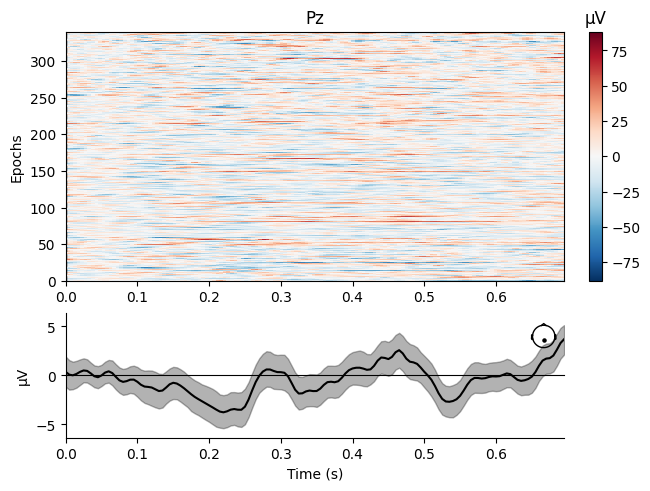

[<Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>]

In [20]:
epochs["1"].plot_image(picks=["Fz", "Cz", "Pz"])

##Plotting sensor locations
Just like Raw objects, Epochs objects keep track of sensor locations, which can be visualized with the plot_sensors method:

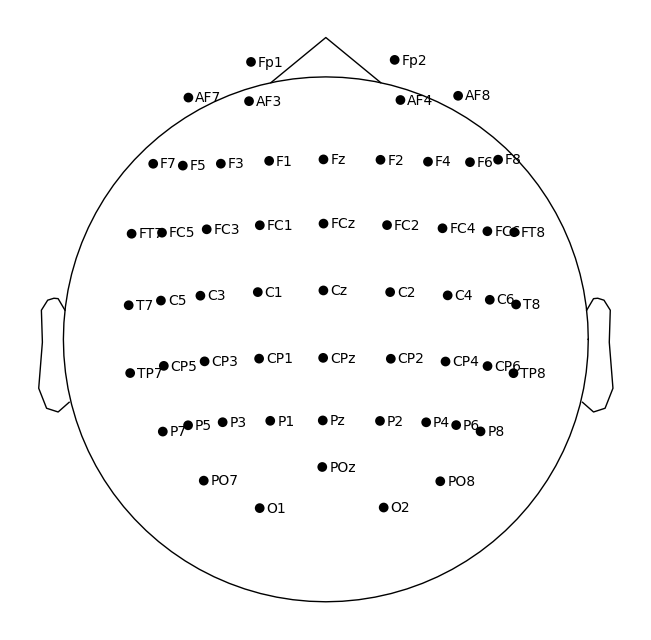

In [21]:
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)
fig = mne.viz.plot_sensors(info, kind='topomap', show_names=True, show=False)
plt.show()

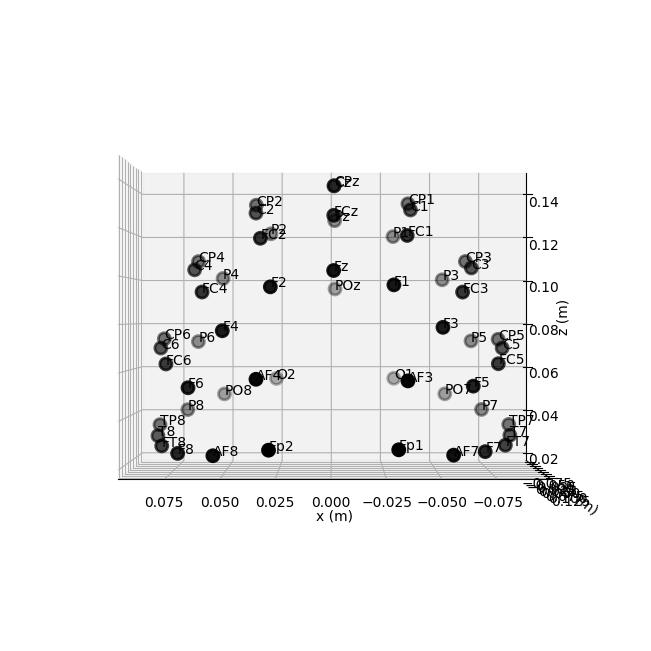

In [22]:
fig = mne.viz.plot_sensors(info, kind='3d', show_names=True, show=False)
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated


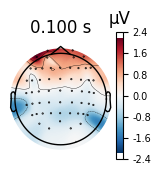

In [23]:
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

# Apply the standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

# Convert data from microvolts to volts
epochs_data = data / 1e6  # MNE expects data in volts

# Create events array, assuming each epoch is an event
events = np.array([[i, 0, 1] for i in range(epochs_data.shape[0])])

# Create MNE Epochs object
epochs = mne.EpochsArray(epochs_data, info, events)

# Compute the average of all epochs
evoked = epochs.average()

# Plot the topomap at a specific time point (e.g., 100 ms)
time_point = 0.1  # time in seconds
fig = evoked.plot_topomap(times=[time_point], ch_type='eeg', show = False)
plt.show()

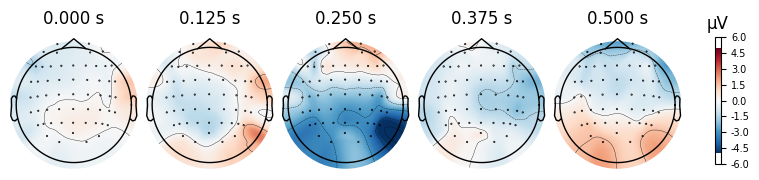

In [24]:
times = np.linspace(0, 0.5, 5)
fig = evoked.plot_topomap(times=times, ch_type='eeg', show = False)
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


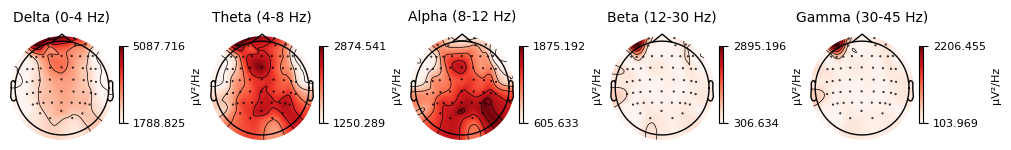

In [25]:
epochs = mne.EpochsArray(epochs_data, info, events)

spectrum = epochs.compute_psd()

fig = spectrum.plot_topomap(show = False)
plt.show()

##Magnetometers and Gradiometers

To plot an image map for all sensors, use plot_topo_image, which is optimized for plotting a large number of image maps simultaneously, and (in interactive sessions) allows you to click on each small image map to pop open a separate figure with the full-sized image plot (as if you had called plot_image on just that sensor). At the small scale shown in this tutorial it’s hard to see much useful detail in these plots; it’s often best when plotting interactively to maximize the topo image plots to fullscreen. The default is a figure with black background, so here we specify a white background and black foreground text. By default plot_topo_image will show magnetometers and gradiometers on the same plot

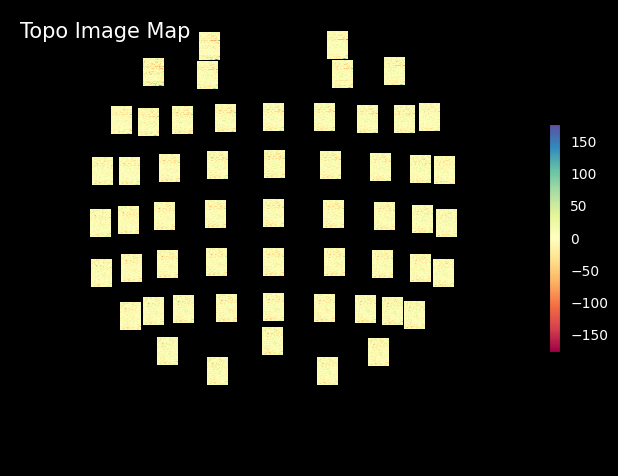

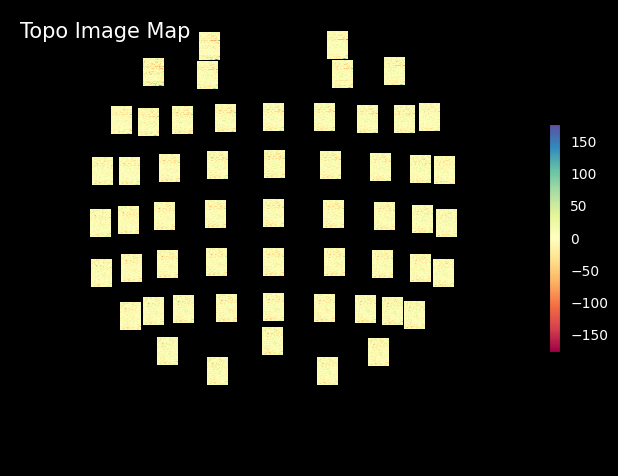

In [26]:
epochs.plot_topo_image(cmap='Spectral', title='Topo Image Map')

In [1]:
# fig = epochs.plot(butterfly=True, scalings='auto', picks='all', show=False)

# fig.subplots_adjust(top=0.9)
# fig.suptitle('Butterfly Plot of Epochs', fontsize=16)

# ax = fig.get_axes()[0]
# lines = ax.get_lines()
# colors = plt.cm.plasma(np.linspace(0, 1, len(lines)))

# ax.grid(True)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Amplitude (V)')

# plt.show()

# TorchEEG

In [ ]:
!pip install torcheeg
import torcheeg
from torcheeg.utils import plot_raw_topomap

  Using cached torcheeg-1.1.2.tar.gz (214 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached spectrum-0.8.1.tar.gz (230 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached mne_connectivity-0.7.0-py3-none-any.whl (115 kB)
  Using cached pytorch_lightning-2.2.5-py3-none-any.whl (802 kB)
  Running setup.py install for spectrum: started
  Running setup.py install for spectrum: finished with status 'error'


  DEPRECATION: spectrum is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for spectrum did not run successfully.
  │ exit code: 1
  ╰─> [47 lines of output]
      running install
      C:\Users\Aditya Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\cpp
      copying src\cpp\__init__.py -> build\lib.win-amd64-cp

  Using cached torcheeg-1.1.2.tar.gz (214 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached spectrum-0.8.1.tar.gz (230 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached mne_connectivity-0.7.0-py3-none-any.whl (115 kB)
  Using cached pytorch_lightning-2.2.5-py3-none-any.whl (802 kB)
  Running setup.py install for spectrum: started
  Running setup.py install for spectrum: finished with status 'error'


  DEPRECATION: spectrum is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for spectrum did not run successfully.
  │ exit code: 1
  ╰─> [47 lines of output]
      running install
      C:\Users\Aditya Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\cpp
      copying src\cpp\__init__.py -> build\lib.win-amd64-cp

ModuleNotFoundError: No module named 'torcheeg'

#Topomap :
displays the spatial distribution of electrical activity across the scalp.

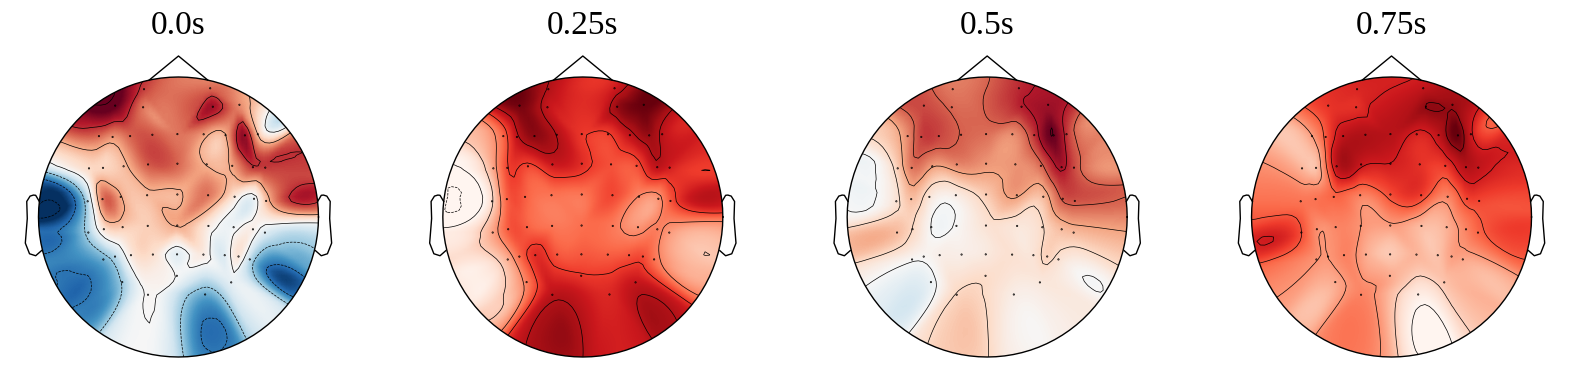

In [ ]:
CUSTOM_CHANNEL_LIST = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
                       'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
                       'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
                       'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
                       'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
                       'PO7', 'POz', 'PO8', 'O1', 'O2']

train_data_list = np.load('/content/drive/My Drive/data/train_data.npy')

# Assuming 'train_data_list' is in the shape (subjects, epochs, channels, times)
# We'll use data from the first subject and first epoch for this example
subject_id = 0
epoch_id = 0
data = train_data_list[subject_id, epoch_id]

# Convert your data to a torch tensor
# Ensure the data shape is (channels, times)
eeg_data = torch.tensor(data)

# Define the sampling rate
sampling_rate = 140

# Plot the topomap
img = plot_raw_topomap(eeg_data, channel_list=CUSTOM_CHANNEL_LIST, sampling_rate=sampling_rate)
plt.show()

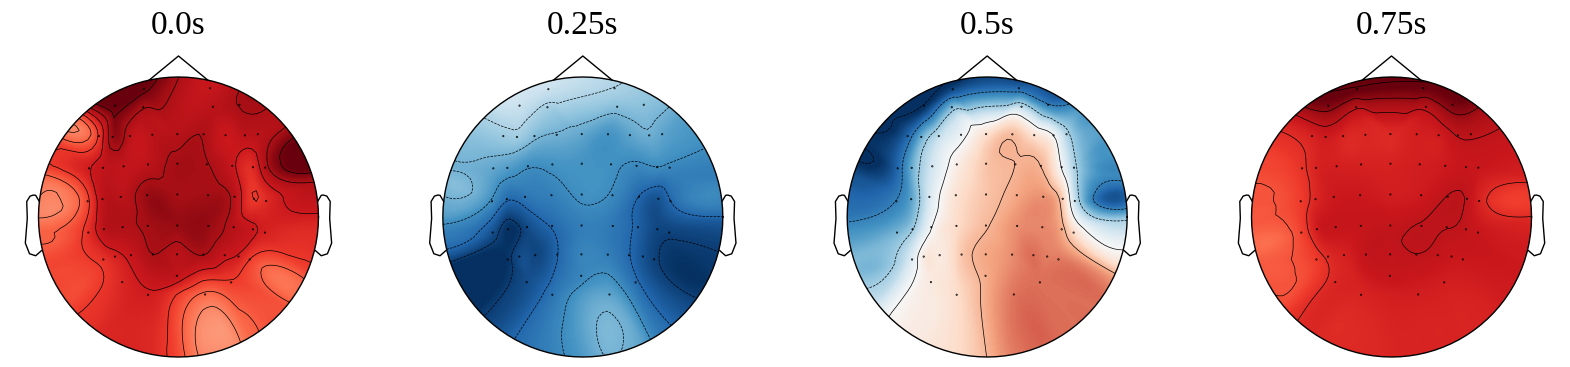

In [ ]:
average_across_epochs = np.mean(train_data_list[subject_id], axis=0)
avg_eeg_data = torch.tensor(average_across_epochs)
img = plot_raw_topomap(avg_eeg_data, channel_list=CUSTOM_CHANNEL_LIST, sampling_rate=sampling_rate)
plt.show()

##Feature Topomap
**Theta Power Topomap (4 - 8 Hz)**: Displays areas associated with drowsiness or deep relaxation  
**Alpha Power Topomap(8 - 12 Hz)**: Shows which areas of the brain are most active in the alpha frequency range, indicating regions of relaxation.  
**Beta Power Topomap(12 - 30 Hz)**: Highlights areas of active thinking and concentration.  
**Gamma Power Topomap(30 - 100 Hz)**: Illustrates regions involved in high-level cognitive processing.  


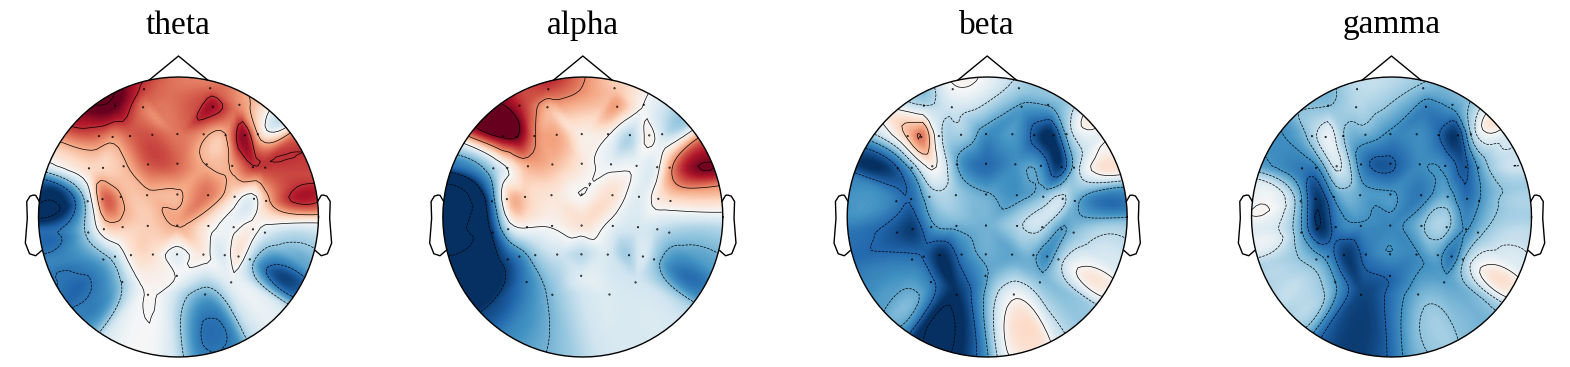

In [ ]:
from torcheeg.utils import plot_feature_topomap

img = plot_feature_topomap(eeg_data,
                 channel_list=CUSTOM_CHANNEL_LIST,
                 feature_list=["theta", "alpha", "beta", "gamma"])
plt.show()

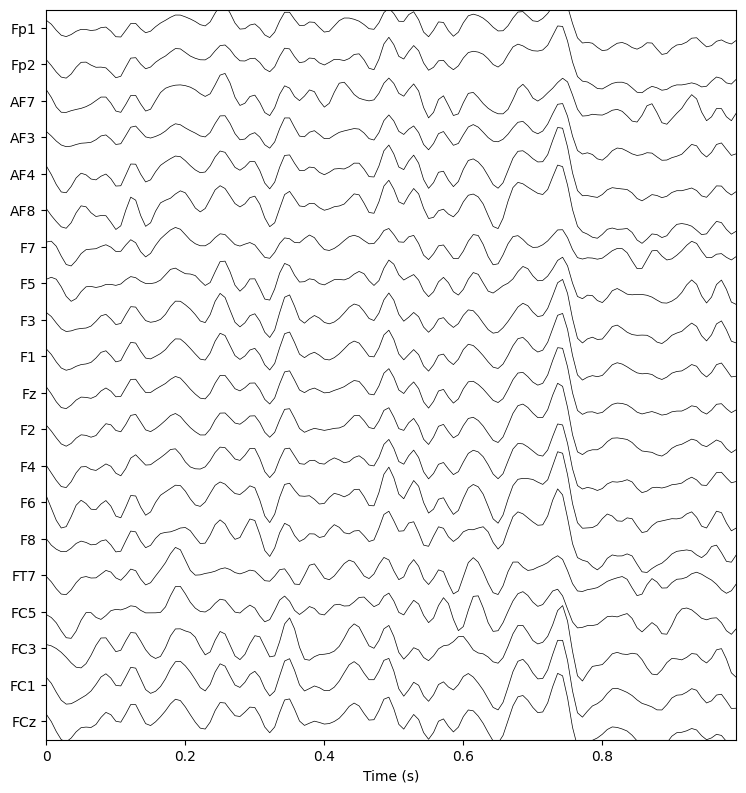

In [ ]:
from torcheeg.utils import plot_signal
img = plot_signal(eeg_data,
                  channel_list=CUSTOM_CHANNEL_LIST,
                  sampling_rate=140)

In [ ]:
from torcheeg.utils import plot_3d_tensor
subject_id = 0
data_for_subject = train_data_list[subject_id]

# Convert the reshaped data to a torch tensor
eeg_data_tensor = torch.tensor(data_for_subject)

# Now, we can plot the 3D tensor
print("Number of dimensions:", eeg_data_tensor.ndim)
print("Shape of the tensor:", eeg_data_tensor.shape)

Number of dimensions: 3
Shape of the tensor: torch.Size([340, 56, 140])


In [ ]:
from torcheeg.utils import plot_2d_tensor
data = train_data_list[0, 0, :, :]
tensor_data = torch.tensor(data)
print(tensor_data.shape)

torch.Size([56, 140])


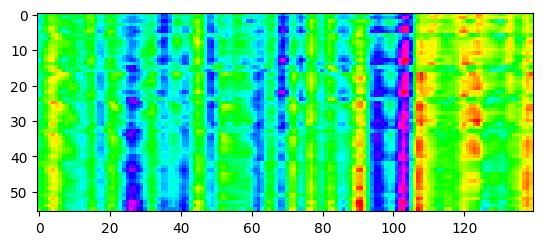

In [ ]:
img = plot_2d_tensor(tensor_data)

In [ ]:
train_data_tensor = torch.tensor(train_data_list)  # Convert NumPy array to PyTorch tensor

subject_id = 0
num_epochs = train_data_tensor.shape[1]
num_times = train_data_tensor.shape[3]

# Compute the mean across the channels dimension for each epoch at each time point
mean_data = torch.mean(train_data_tensor[subject_id], dim=1)  # Mean across the channels dimension

# Reshape the mean_data to a 2D array
mean_data_2d = mean_data.view(num_epochs, num_times)

# Convert to a NumPy array if needed
data = mean_data_2d.numpy()
data = data.T
tensor_data = torch.tensor(data)
print(tensor_data.shape)

torch.Size([140, 340])


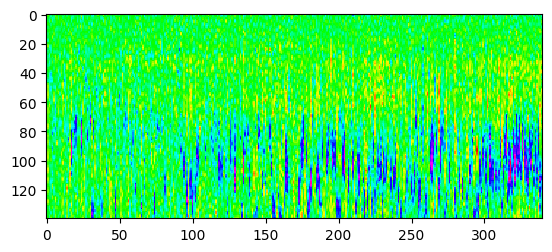

In [ ]:
plt = plot_2d_tensor(tensor_data)

In [104]:
# img = plot_3d_tensor(eeg_data_tensor)

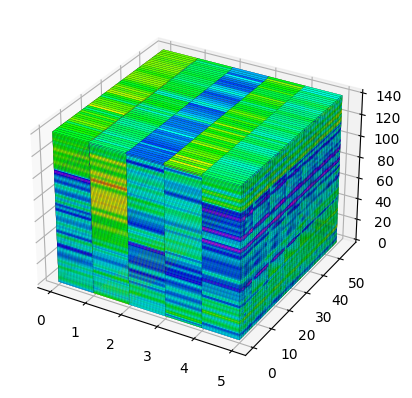

In [ ]:
from torcheeg.utils import plot_3d_tensor
subject_id = 0
data_for_subject = train_data_list[subject_id, :5, :, :]

# Convert the reshaped data to a torch tensor
eeg_data_tensor = torch.tensor(data_for_subject)

# Now, we can plot the 3D tensor
img = plot_3d_tensor(eeg_data_tensor)

# Random Forest

In [27]:
!pip install pyriemann
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

     -------------------------------------- 111.7/111.7 kB 1.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
Y_train = pd.read_csv('TrainLabels.csv')['Prediction'].values

In [28]:
if not isfile('X_train.npy'):
    XC = XdawnCovariances(nfilter=5) # our transformer
    TS = TangentSpace(metric='riemann')
    test_data = np.reshape(test_data_list,
    (test_subj_num * stimulus_per_subj, len(channels), epoch_len))
    train_data = np.reshape(train_data_list,
    (train_subj_num * stimulus_per_subj, len(channels), epoch_len))

    X_train = XC.fit_transform(train_data, Y_train)
    X_train = TS.fit_transform(X_train)
    X_test = XC.transform(test_data)
    X_test = TS.transform(X_test)

    np.save('X_train', X_train)
    np.save('X_test', X_test)
    np.save('Y_train', Y_train)

In [29]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
Y_train = np.load('Y_train.npy')

# Only used for scoring
Y_test = np.reshape(pd.read_csv('true_labels.csv', header=None).values, 3400)

In [71]:
print('Transformed training data shape: ' + str(X_train.shape))
print('Training label shape: ' + str(Y_train.shape))
print('Transformed testing data shape: ' + str(X_test.shape))
print('Testing label shape: ' + str(Y_test.shape))

Transformed training data shape: (5440, 210)
Training label shape: (5440,)
Transformed testing data shape: (3400, 210)
Testing label shape: (3400,)


In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 1000]
}

if not isfile('random_forest_gs'):
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
               cv = 4, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    pickle.dump(grid_search, open('random_forest_gs', 'wb'))

In [86]:
grid_search = pickle.load(open('random_forest_gs', 'rb'))
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'n_estimators': 200}


Average inference time over 20 runs: 8.2803 seconds
Accuracy: 0.76


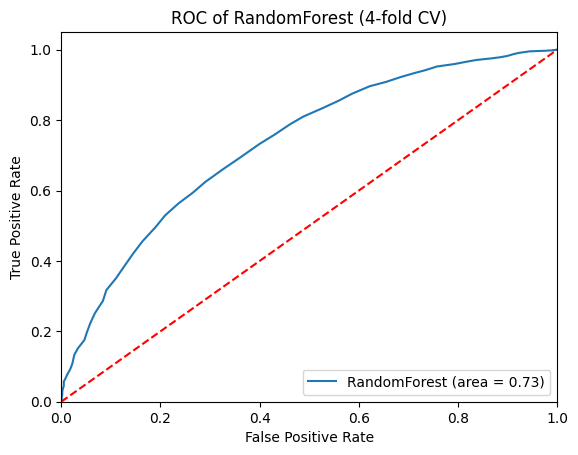

0.7326600485892306


In [87]:
from sklearn.metrics import roc_auc_score, roc_curve

Y_pred_proba = grid_search.predict_proba(X_test)

num_runs = 20
inference_times = []

for _ in range(num_runs):
    start_time = time.time()
    y_pred = sclf.predict(X_test)
    end_time = time.time()
    inference_time = end_time - start_time
    inference_times.append(inference_time)

# Calculate average inference time
average_inference_time = np.mean(inference_times)
print(f'Average inference time over {num_runs} runs: {average_inference_time:.4f} seconds')

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

r_roc_auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest (area = %0.2f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RandomForest (4-fold CV)')
plt.legend(loc="lower right")
plt.savefig('random_forest.png')
plt.show()
print(r_roc_auc)

# StackNet

In [56]:
!pip install mlxtend
!pip install lightgbm
!pip install xgboost


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingCVClassifier


In [83]:
# Load your data (replace with your actual data loading code)
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
X_test = np.load('X_test.npy')

# Define base classifiers for the stacking layer
base_classifiers = [
    LDA(solver='lsqr', shrinkage='auto'),
    SVC(class_weight='balanced', probability=True, kernel='rbf', gamma=0.001, C=1),
    LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=100000, C=1),
    LGBMClassifier(num_leaves=40, learning_rate=0.01, n_estimators=1000, class_weight='balanced', subsample=0.9, colsample_bytree=0.5, random_state=1),
    GaussianProcessClassifier(),
    XGBClassifier(max_depth=5, learning_rate=0.3, n_estimators=300, objective="binary:logistic", booster="gblinear", random_state=1, colsample_bytree=0.4),
    XGBClassifier(max_depth=20, learning_rate=0.1, n_estimators=300, objective="binary:logistic", booster="gbtree", random_state=1, colsample_bytree=0.4),
    XGBClassifier(max_depth=100, learning_rate=0.1, n_estimators=300, objective="rank:pairwise", booster="gbtree", random_state=1, colsample_bytree=0.4)
]

# Define the meta-classifier for the stacking layer
meta_classifier = LogisticRegression()

# Create StackingCVClassifier with one layer
sclf = StackingCVClassifier(classifiers=base_classifiers,
                            meta_classifier=meta_classifier,
                            use_probas=True,  # Set to True if using predict_proba
                            cv=3,
                            random_state=42,
                            n_jobs=-1)  # Use all available CPU cores

# Fit the StackingCVClassifier
sclf.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 3850, number of negative: 1590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53550
[LightGBM] [Info] Number of data points in the train set: 5440, number of used features: 210
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\Aditya Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


StackingCVClassifier(classifiers=[LinearDiscriminantAnalysis(shrinkage='auto',
                                                             solver='lsqr'),
                                  SVC(C=1, class_weight='balanced', gamma=0.001,
                                      probability=True),
                                  LogisticRegression(C=1,
                                                     class_weight='balanced',
                                                     max_iter=100000),
                                  LGBMClassifier(class_weight='balanced',
                                                 colsample_bytree=0.5,
                                                 learning_rate=0.01,
                                                 n_estimators=1000,
                                                 num_leaves=40, random_state=1,
                                                 subsa...
                                                learning_rate=0.1, max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=100, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                multi_strategy=None,
                                                n_estimators=300, n_jobs=None,
                                                num_parallel_tree=None,
                                                objective='rank:pairwise', ...)],
                     cv=3, meta_classifier=LogisticRegression(), n_jobs=-1,
                     random_state=42, use_probas=True)

ROC AUC: 0.76
Average inference time over 20 runs: 8.2179 seconds
Accuracy: 0.76


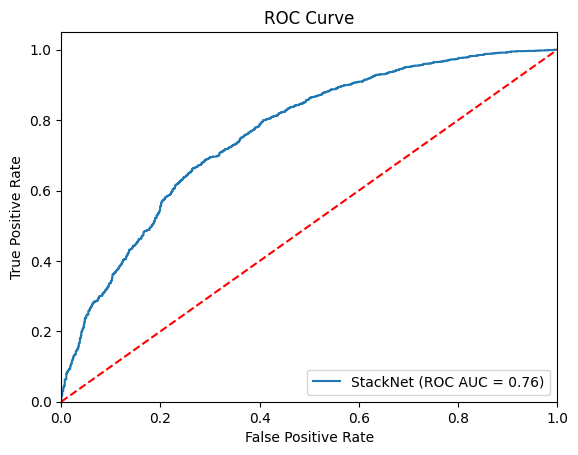

In [84]:
import time
y_probs = sclf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(Y_test, y_probs)
print(f"ROC AUC: {roc_auc:.2f}")

num_runs = 20
inference_times = []

for _ in range(num_runs):
    start_time = time.time()
    y_pred = sclf.predict(X_test)
    end_time = time.time()
    inference_time = end_time - start_time
    inference_times.append(inference_time)

# Calculate average inference time
average_inference_time = np.mean(inference_times)
print(f'Average inference time over {num_runs} runs: {average_inference_time:.4f} seconds')

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'StackNet (ROC AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# EEGNet Fail

In [81]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)




def EEGNet_SSVEP(nb_classes = 12, Chans = 8, Samples = 256, 
             dropoutRate = 0.5, kernLength = 256, F1 = 96, 
             D = 1, F2 = 96, dropoutType = 'Dropout'):
    """ SSVEP Variant of EEGNet, as used in [1]. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. 
      D               : number of spatial filters to learn within each temporal
                        convolution.
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
      
      
    [1]. Waytowich, N. et. al. (2018). Compact Convolutional Neural Networks
    for Classification of Asynchronous Steady-State Visual Evoked Potentials.
    Journal of Neural Engineering vol. 15(6). 
    http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)



def EEGNet_old(nb_classes, Chans = 64, Samples = 128, regRate = 0.0001,
           dropoutRate = 0.25, kernels = [(2, 32), (8, 4)], strides = (2, 4)):
    """ Keras Implementation of EEGNet_v1 (https://arxiv.org/abs/1611.08024v2)

    This model is the original EEGNet model proposed on arxiv
            https://arxiv.org/abs/1611.08024v2
    
    with a few modifications: we use striding instead of max-pooling as this 
    helped slightly in classification performance while also providing a 
    computational speed-up. 
    
    Note that we no longer recommend the use of this architecture, as the new
    version of EEGNet performs much better overall and has nicer properties.
    
    Inputs:
        
        nb_classes     : total number of final categories
        Chans, Samples : number of EEG channels and samples, respectively
        regRate        : regularization rate for L1 and L2 regularizations
        dropoutRate    : dropout fraction
        kernels        : the 2nd and 3rd layer kernel dimensions (default is 
                         the [2, 32] x [8, 4] configuration)
        strides        : the stride size (note that this replaces the max-pool
                         used in the original paper)
    
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    layer1       = Conv2D(16, (Chans, 1), input_shape=(1, Chans, Samples),
                                 kernel_regularizer = l1_l2(l1=regRate, l2=regRate))(input_main)
    layer1       = BatchNormalization(axis=1)(layer1)
    layer1       = Activation('elu')(layer1)
    layer1       = Dropout(dropoutRate)(layer1)
    
    permute_dims = 2, 1, 3
    permute1     = Permute(permute_dims)(layer1)
    
    layer2       = Conv2D(4, kernels[0], padding = 'same', 
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(permute1)
    layer2       = BatchNormalization(axis=1)(layer2)
    layer2       = Activation('elu')(layer2)
    layer2       = Dropout(dropoutRate)(layer2)
    
    layer3       = Conv2D(4, kernels[1], padding = 'same',
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(layer2)
    layer3       = BatchNormalization(axis=1)(layer3)
    layer3       = Activation('elu')(layer3)
    layer3       = Dropout(dropoutRate)(layer3)
    
    flatten      = Flatten(name = 'flatten')(layer3)
    
    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)



def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)


# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   


def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

In [96]:
X_train_valid0 = np.load('train_data.npy')
X_train_valid = np.zeros((X_train_valid0.shape[0] * X_train_valid0.shape[1], 56, 140))
for i in range(X_train_valid0.shape[0]):
  for j in range(X_train_valid0.shape[1]):
    for k in range(X_train_valid0.shape[2]):
      # Access the second column element and place it in the first column of the reshaped array
      X_train_valid[i * X_train_valid0.shape[1] + j, k, :] = X_train_valid0[i, j, 1, :]

print("Original array shape:", X_train_valid0.shape)
print("Reshaped array shape:", X_train_valid.shape)


X_test0 = np.load('test_data.npy')
X_test = np.zeros((X_test0.shape[0] * X_test0.shape[1], 56, 140))
for i in range(X_test0.shape[0]):
  for j in range(X_test0.shape[1]):
    for k in range(X_test0.shape[2]):
      # Access the second column element and place it in the first column of the reshaped array
      X_test[i * X_test0.shape[1] + j, k, :] = X_test0[i, j, 1, :]

print("Original array shape:", X_test0.shape)
print("Reshaped array shape:", X_test.shape)


Original array shape: (16, 340, 56, 140)
Reshaped array shape: (5440, 56, 140)
Original array shape: (10, 340, 56, 140)
Reshaped array shape: (3400, 56, 140)


In [101]:
from tensorflow.keras import optimizers
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_auc_score


y_train_valid = pd.read_csv('TrainLabels.csv')['Prediction'].values


y_test = np.reshape(pd.read_csv(
    'true_labels.csv', header=None).values, 3400)

# data partition
X_train = X_train_valid[1360:, :]
X_valid = X_train_valid[:1360, :]
y_train = y_train_valid[1360:]
y_valid = y_train_valid[:1360]

kernels, chans, samples = 1, 56, 140

X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_valid = X_valid.reshape(X_valid.shape[0], kernels, chans, samples)
X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

print(str(X_train.shape[0]) + ' train samples')
print(str(X_valid.shape[0]) + ' validation samples')
print(str(X_test.shape[0]) + ' test samples')

# configure EEGNET model
model = EEGNet(nb_classes=2, Chans=chans, Samples=samples,
               dropoutRate=0.5, kernLength=100, F1=1, D=2, F2=16,
               dropoutType='Dropout')

# compile the model and set the optimizers
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# count number of parameters in the model
numParams = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

# Weighted loss
weight_0 = 1/(len([y for y in y_train_valid if y == 0]))
weight_1 = 1/(len([y for y in y_train_valid if y == 1]))
class_weights = {0: weight_0, 1: weight_1}
#
# # fit the model
fittedModel = model.fit(X_train, y_train, batch_size=34, epochs=100,
                        verbose=2, validation_data=(X_valid, y_valid),
                        callbacks=[checkpointer], class_weight=class_weights)

# load optimal weights
model.load_weights('/tmp/checkpoint.h5')

# Evaluate
y_probs = model.predict(X_test)
y_pred = y_probs.argmax(axis=-1)

# save score
csv = pd.read_csv('./data/benchmark.csv')
csv['Prediction'] = y_probs
csv.to_csv('./submission/submissionEEGNET.csv', index=False)
print('--------------------Submission file has been generated.--------------------------')

4080 train samples
1360 validation samples
3400 test samples


c:\Users\Aditya Kumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling DepthwiseConv2D.call().

[1mComputed output size would be negative. Received `inputs shape=(None, 1, 56, 1)`, `kernel shape=(56, 1, 1, 2)`, `dilation_rate=[1 1]`.[0m

Arguments received by DepthwiseConv2D.call():
  • args=('<KerasTensor shape=(None, 1, 56, 1), dtype=float32, sparse=False, name=keras_tensor_11>',)
  • kwargs=<class 'inspect._empty'>

# EEGNet

In [15]:
!pip install mne torch



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

In [76]:
# Load train and test data
train_data_list = np.load('train_data.npy')
test_data_list = np.load('test_data.npy')

# Combine data from all subjects
X_train = train_data_list.reshape(-1, 56, 140)
X_test = test_data_list.reshape(-1, 56, 140)
Y_train = np.load('Y_train.npy')
Y_test = np.reshape(pd.read_csv('true_labels.csv', header=None).values, 3400)

# Normalize data
# X_train = (X_train - X_train.mean()) / X_train.std()
# X_test = (X_test - X_test.mean()) / X_test.std()

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [77]:
# Define EEGNet model
class EEGNet(nn.Module):
    def __init__(self, num_classes):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 51), padding=(0, 25)),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (56, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 15), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.25)
        )
        self._num_features_for_linear = self._get_conv_output((1, 56, 140))
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._num_features_for_linear, num_classes)
        )

    def _get_conv_output(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.firstconv(x)
            x = self.depthwiseConv(x)
            x = self.separableConv(x)
            x = x.view(1, -1)
            return x.size(1)

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classify(x)
        return x

model = EEGNet(num_classes=2)
torchinfo.summary(model, input_size=(32, 1, 56, 140))

Layer (type:depth-idx)                   Output Shape              Param #
EEGNet                                   [32, 2]                   --
├─Sequential: 1-1                        [32, 16, 56, 140]         --
│    └─Conv2d: 2-1                       [32, 16, 56, 140]         832
│    └─BatchNorm2d: 2-2                  [32, 16, 56, 140]         32
├─Sequential: 1-2                        [32, 32, 1, 35]           --
│    └─Conv2d: 2-3                       [32, 32, 1, 140]          1,792
│    └─BatchNorm2d: 2-4                  [32, 32, 1, 140]          64
│    └─ELU: 2-5                          [32, 32, 1, 140]          --
│    └─AvgPool2d: 2-6                    [32, 32, 1, 35]           --
│    └─Dropout: 2-7                      [32, 32, 1, 35]           --
├─Sequential: 1-3                        [32, 32, 1, 4]            --
│    └─Conv2d: 2-8                       [32, 32, 1, 35]           15,360
│    └─BatchNorm2d: 2-9                  [32, 32, 1, 35]           64
│    └─

Epoch 1/200, Loss: 0.6433
Epoch 2/200, Loss: 0.6021
Epoch 3/200, Loss: 0.5972
Epoch 4/200, Loss: 0.5962
Epoch 5/200, Loss: 0.5813
Epoch 6/200, Loss: 0.5761
Epoch 7/200, Loss: 0.5737
Epoch 8/200, Loss: 0.5677
Epoch 9/200, Loss: 0.5571
Epoch 10/200, Loss: 0.5651
Epoch 11/200, Loss: 0.5565
Epoch 12/200, Loss: 0.5496
Epoch 13/200, Loss: 0.5464
Epoch 14/200, Loss: 0.5459
Epoch 15/200, Loss: 0.5408
Epoch 16/200, Loss: 0.5384
Epoch 17/200, Loss: 0.5261
Epoch 18/200, Loss: 0.5299
Epoch 19/200, Loss: 0.5210
Epoch 20/200, Loss: 0.5216
Epoch 21/200, Loss: 0.5223
Epoch 22/200, Loss: 0.5083
Epoch 23/200, Loss: 0.5126
Epoch 24/200, Loss: 0.5123
Epoch 25/200, Loss: 0.5053
Epoch 26/200, Loss: 0.5028
Epoch 27/200, Loss: 0.4929
Epoch 28/200, Loss: 0.5000
Epoch 29/200, Loss: 0.4850
Epoch 30/200, Loss: 0.4909
Epoch 31/200, Loss: 0.4796
Epoch 32/200, Loss: 0.4887
Epoch 33/200, Loss: 0.4881
Epoch 34/200, Loss: 0.4784
Epoch 35/200, Loss: 0.4816
Epoch 36/200, Loss: 0.4730
Epoch 37/200, Loss: 0.4755
Epoch 38/2

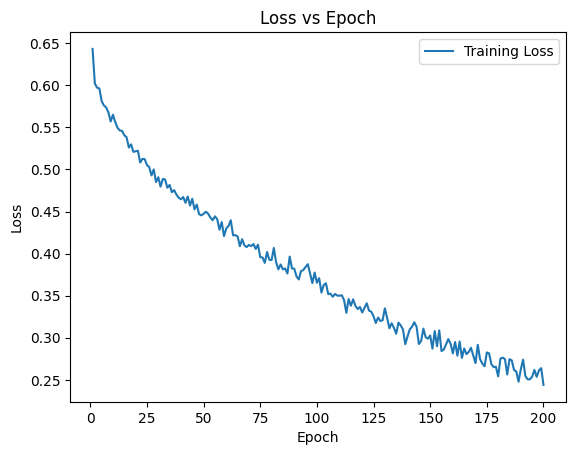

In [19]:
# Create model instance

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
num_epochs = 200

# Lists to store losses and epochs
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)  # Add channel dimension for Conv2d input
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Plotting the loss vs epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [20]:
# Evaluate the model
model.eval()
total = 0
correct = 0
all_labels = []
all_probs = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.unsqueeze(1)  # Add channel dimension for Conv2d input
        outputs = model(data)
        probs = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_labels.extend(target.numpy())
        all_probs.extend(probs.numpy()[:, 1])  # Get probabilities for class 1

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 75.32352941176471%


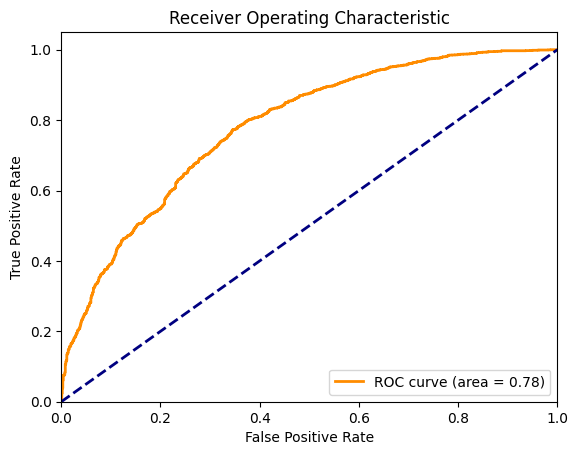

In [21]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [80]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
num_epochs = 1

# Lists to store losses and epochs
epoch_losses = []
import time
import torch
import torch.nn as nn

# Define the number of runs
num_runs = 20

model.eval()
total = 0
correct = 0
all_labels = []
all_probs = []
inference_times = []

for run in range(num_runs):
    # Measure inference time
    start_time = time.time()
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.unsqueeze(1)  # Add channel dimension for Conv2d input
            outputs = model(data)
            probs = nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_labels.extend(target.numpy())
            all_probs.extend(probs.numpy()[:, 1])  # Get probabilities for class 1
    
    end_time = time.time()
    inference_time = end_time - start_time
    inference_times.append(inference_time)

# Calculate average inference time
average_inference_time = sum(inference_times) / num_runs

print(f'Accuracy: {100 * correct / total}%')
print(f'Average inference time over {num_runs} runs: {average_inference_time:.4f} seconds')


Accuracy: 67.02941176470588%
Average inference time over 20 runs: 1.7969 seconds


# LMDANet

In [13]:
!pip install torchinfo


[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torchinfo

In [30]:
train_data_list = np.load('train_data.npy')  
test_data_list = np.load('test_data.npy') 
# Reshape the data
train_data = train_data_list.reshape(-1, 1, 56, 140)
test_data = test_data_list.reshape(-1, 1, 56, 140)

# Convert data to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)
train_labels = torch.tensor(Y_train, dtype=torch.long)
test_labels = torch.tensor(Y_test, dtype=torch.long)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
# Define the LMDA model
class EEGDepthAttention(nn.Module):
    def __init__(self, W, C, k=7):
        super(EEGDepthAttention, self).__init__()
        self.C = C
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, W))
        self.conv = nn.Conv2d(1, 1, kernel_size=(k, 1), padding=(k // 2, 0), bias=True)
        self.softmax = nn.Softmax(dim=-2)

    def forward(self, x):
        x_pool = self.adaptive_pool(x)
        x_transpose = x_pool.transpose(-2, -3)
        y = self.conv(x_transpose)
        y = self.softmax(y)
        y = y.transpose(-2, -3)
        return y * self.C * x
class LMDA(nn.Module):
    def __init__(self, chans=22, samples=1125, num_classes=4, depth=9, kernel=75, channel_depth1=24, channel_depth2=9,
                ave_depth=1, avepool=5):
        super(LMDA, self).__init__()
        self.ave_depth = ave_depth
        self.channel_weight = nn.Parameter(torch.randn(depth, 1, chans), requires_grad=True)
        nn.init.xavier_uniform_(self.channel_weight.data)

        self.time_conv = nn.Sequential(
            nn.Conv2d(depth, channel_depth1, kernel_size=(1, 1), groups=1, bias=False),
            nn.BatchNorm2d(channel_depth1),
            nn.Conv2d(channel_depth1, channel_depth1, kernel_size=(1, kernel),
                      groups=channel_depth1, bias=False),
            nn.BatchNorm2d(channel_depth1),
            nn.GELU(),
        )

        self.chanel_conv = nn.Sequential(
            nn.Conv2d(channel_depth1, channel_depth2, kernel_size=(1, 1), groups=1, bias=False),
            nn.BatchNorm2d(channel_depth2),
            nn.Conv2d(channel_depth2, channel_depth2, kernel_size=(chans, 1), groups=channel_depth2, bias=False),
            nn.BatchNorm2d(channel_depth2),
            nn.GELU(),
        )

        self.norm = nn.Sequential(
            nn.AvgPool3d(kernel_size=(1, 1, avepool)),
            nn.Dropout(p=0.65),
        )

        out = torch.ones((1, depth, chans, samples))  # Adjusted to have depth dimension
        out = torch.einsum('bdcw, hdc->bhcw', out, self.channel_weight)
        out = self.time_conv(out)
        N, C, H, W = out.size()

        self.depthAttention = EEGDepthAttention(W, C, k=7)

        out = self.chanel_conv(out)
        out = self.norm(out)
        n_out_time = out.cpu().data.numpy().shape
        print('In ShallowNet, n_out_time shape: ', n_out_time)
        self.classifier = nn.Linear(n_out_time[-1]*n_out_time[-2]*n_out_time[-3], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.einsum('bdcw, hdc->bhcw', x, self.channel_weight)
        x_time = self.time_conv(x)
        x_time = self.depthAttention(x_time)
        x = self.chanel_conv(x_time)
        x = self.norm(x)
        features = torch.flatten(x, 1)
        cls = self.classifier(features)
        return cls

# Instantiate the model
num_classes = len(np.unique(train_labels))
model = LMDA(chans=56, samples=140, num_classes=num_classes, depth=1, kernel=5, channel_depth1=24, channel_depth2=9, ave_depth=1, avepool=5)

# Print the model summary
torchinfo.summary(model, input_size=(32, 1, 56, 140))


In ShallowNet, n_out_time shape:  (1, 9, 1, 27)


Layer (type:depth-idx)                   Output Shape              Param #
LMDA                                     [32, 2]                   56
├─Sequential: 1-1                        [32, 24, 56, 136]         --
│    └─Conv2d: 2-1                       [32, 24, 56, 140]         24
│    └─BatchNorm2d: 2-2                  [32, 24, 56, 140]         48
│    └─Conv2d: 2-3                       [32, 24, 56, 136]         120
│    └─BatchNorm2d: 2-4                  [32, 24, 56, 136]         48
│    └─GELU: 2-5                         [32, 24, 56, 136]         --
├─EEGDepthAttention: 1-2                 [32, 24, 56, 136]         --
│    └─AdaptiveAvgPool2d: 2-6            [32, 24, 1, 136]          --
│    └─Conv2d: 2-7                       [32, 1, 24, 136]          8
│    └─Softmax: 2-8                      [32, 1, 24, 136]          --
├─Sequential: 1-3                        [32, 9, 1, 136]           --
│    └─Conv2d: 2-9                       [32, 9, 56, 136]          216
│    └─BatchNo

In [38]:
!pip install tensorboard


[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer object
writer = SummaryWriter('runs/lmda_net')

# Create a sample input
sample_input = torch.randn((32, 1, 56, 140)).to(device)

# Add the model graph to TensorBoard
writer.add_graph(model, sample_input)

# Close the writer
writer.close()


In [41]:
!tensorboard --logdir=runs

^C


Epoch [1/100], Loss: 0.7511
Epoch [2/100], Loss: 0.6589
Epoch [3/100], Loss: 0.6101
Epoch [4/100], Loss: 0.5872
Epoch [5/100], Loss: 0.5802
Epoch [6/100], Loss: 0.5752
Epoch [7/100], Loss: 0.5676
Epoch [8/100], Loss: 0.5598
Epoch [9/100], Loss: 0.5621
Epoch [10/100], Loss: 0.5533
Epoch [11/100], Loss: 0.5532
Epoch [12/100], Loss: 0.5476
Epoch [13/100], Loss: 0.5503
Epoch [14/100], Loss: 0.5464
Epoch [15/100], Loss: 0.5392
Epoch [16/100], Loss: 0.5390
Epoch [17/100], Loss: 0.5370
Epoch [18/100], Loss: 0.5358
Epoch [19/100], Loss: 0.5349
Epoch [20/100], Loss: 0.5375
Epoch [21/100], Loss: 0.5351
Epoch [22/100], Loss: 0.5323
Epoch [23/100], Loss: 0.5321
Epoch [24/100], Loss: 0.5277
Epoch [25/100], Loss: 0.5282
Epoch [26/100], Loss: 0.5177
Epoch [27/100], Loss: 0.5197
Epoch [28/100], Loss: 0.5187
Epoch [29/100], Loss: 0.5201
Epoch [30/100], Loss: 0.5133
Epoch [31/100], Loss: 0.5172
Epoch [32/100], Loss: 0.5153
Epoch [33/100], Loss: 0.5156
Epoch [34/100], Loss: 0.5140
Epoch [35/100], Loss: 0

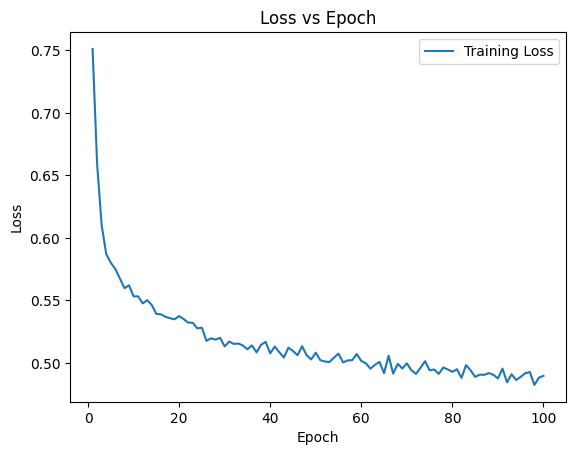

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
num_epochs = 100

# List to store loss values
epoch_losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Plotting the loss vs epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [59]:
# Evaluate the model
accuracy = 0
model.eval()
all_targets = []
all_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.numpy())
        all_predictions.extend(predicted.numpy())

accuracy += accuracy_score(all_targets, all_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 80.68%


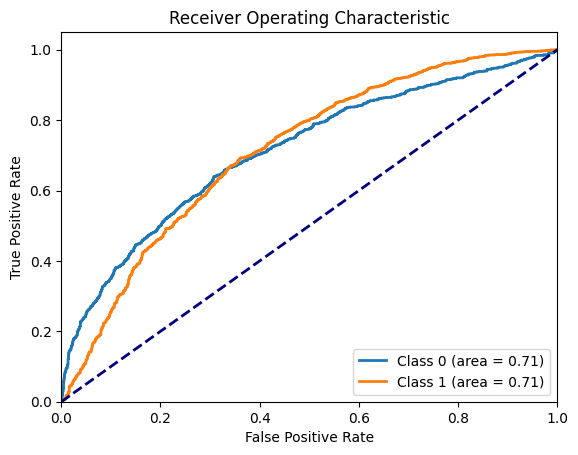

In [37]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding for ROC curve
num_classes = len(np.unique(train_labels))
all_targets_onehot = np.eye(num_classes)[all_targets]

# Get scores for ROC curve
all_scores = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        scores = torch.softmax(model(data), dim=1).numpy()
        all_scores.extend(scores)

all_scores = np.array(all_scores)

# Plot ROC curve for each class
plt.figure()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_targets_onehot[:, i], all_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

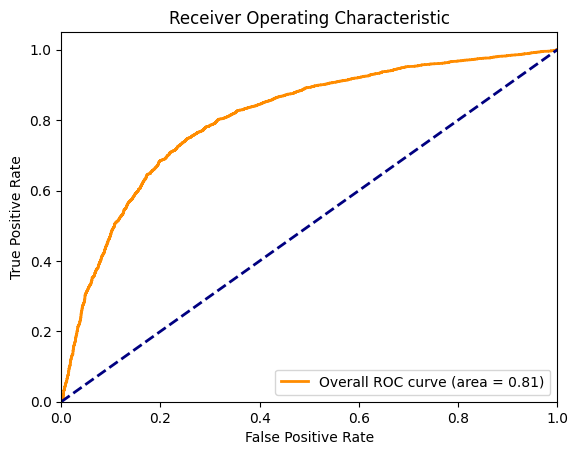

In [38]:
fpr, tpr, _ = roc_curve(all_targets_onehot.ravel(), all_scores.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Epoch [1/150], Loss: 0.4620
Epoch [2/150], Loss: 0.4590
Epoch [3/150], Loss: 0.4544
Epoch [4/150], Loss: 0.4641
Epoch [5/150], Loss: 0.4547
Epoch [6/150], Loss: 0.4603
Epoch [7/150], Loss: 0.4594
Epoch [8/150], Loss: 0.4632
Epoch [9/150], Loss: 0.4528
Epoch [10/150], Loss: 0.4627
Epoch [11/150], Loss: 0.4642
Epoch [12/150], Loss: 0.4617
Epoch [13/150], Loss: 0.4637
Epoch [14/150], Loss: 0.4607
Epoch [15/150], Loss: 0.4589
Epoch [16/150], Loss: 0.4608
Epoch [17/150], Loss: 0.4561
Epoch [18/150], Loss: 0.4724
Epoch [19/150], Loss: 0.4633
Epoch [20/150], Loss: 0.4544
Epoch [21/150], Loss: 0.4610
Epoch [22/150], Loss: 0.4588
Epoch [23/150], Loss: 0.4580
Epoch [24/150], Loss: 0.4549
Epoch [25/150], Loss: 0.4579
Epoch [26/150], Loss: 0.4645
Epoch [27/150], Loss: 0.4612
Epoch [28/150], Loss: 0.4574
Epoch [29/150], Loss: 0.4600
Epoch [30/150], Loss: 0.4502
Epoch [31/150], Loss: 0.4590
Epoch [32/150], Loss: 0.4590
Epoch [33/150], Loss: 0.4594
Epoch [34/150], Loss: 0.4598
Epoch [35/150], Loss: 0

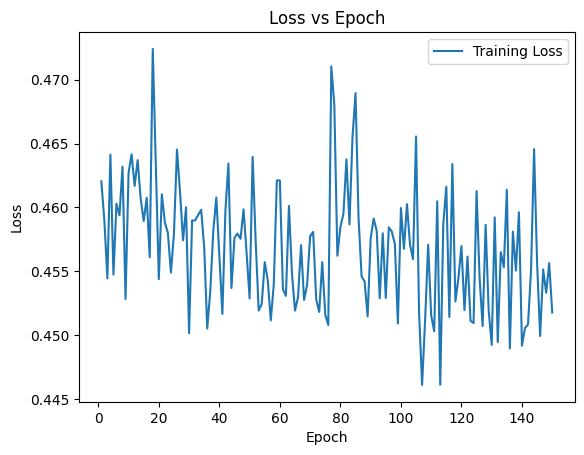

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
num_epochs = 150

# List to store loss values
epoch_losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Plotting the loss vs epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [44]:
# Evaluate the model
model.eval()
all_targets = []
all_predictions = []
accuracy = 0.0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.numpy())
        all_predictions.extend(predicted.numpy())

accuracy += accuracy_score(all_targets, all_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 74.47%


# Temporal Attention

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torchinfo

# Replace these with your actual data loading code
train_data_list = np.load('train_data.npy')
test_data_list = np.load('test_data.npy')

# Reshape the data
train_data = train_data_list.reshape(-1, 1, 56, 140)
test_data = test_data_list.reshape(-1, 1, 56, 140)

# Convert data to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)
train_labels = torch.tensor(Y_train, dtype=torch.long)
test_labels = torch.tensor(Y_test, dtype=torch.long)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\Aditya Kumar\AppData\Local\Temp\ipykernel_31648\2146156398.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(Y_train, dtype=torch.long)
C:\Users\Aditya Kumar\AppData\Local\Temp\ipykernel_31648\2146156398.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(Y_test, dtype=torch.long)


In [36]:
# Define the EEGDepthAttention model
class EEGDepthAttention(nn.Module):
    def __init__(self, W, C, k=7):
        super(EEGDepthAttention, self).__init__()
        self.C = C
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, W))
        self.conv = nn.Conv2d(1, 1, kernel_size=(k, 1), padding=(k // 2, 0), bias=True)
        self.softmax = nn.Softmax(dim=-2)

    def forward(self, x):
        x_pool = self.adaptive_pool(x)
        x_transpose = x_pool.transpose(-2, -3)
        y = self.conv(x_transpose)
        y = self.softmax(y)
        y = y.transpose(-2, -3)
        return y * self.C * x

class TemporalAttention(nn.Module):
    def __init__(self, chans, samples, kernel=7):
        super(TemporalAttention, self).__init__()
        self.conv = nn.Conv1d(chans, chans, kernel_size=kernel, padding=kernel//2, groups=chans)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.squeeze(1)  # Remove the single channel dimension
        attn_weights = self.conv(x)
        attn_weights = self.softmax(attn_weights)
        x = x * attn_weights
        x = x.unsqueeze(1)  # Add the single channel dimension back
        return x

class LMDA(nn.Module):
    def __init__(self, chans=22, samples=1125, num_classes=4, depth=9, kernel=75, channel_depth1=24, channel_depth2=9,
                ave_depth=1, avepool=5):
        super(LMDA, self).__init__()
        self.ave_depth = ave_depth
        self.channel_weight = nn.Parameter(torch.randn(depth, 1, chans), requires_grad=True)
        nn.init.xavier_uniform_(self.channel_weight.data)

        self.temporal_attention = TemporalAttention(chans, samples)

        self.time_conv = nn.Sequential(
            nn.Conv2d(depth, channel_depth1, kernel_size=(1, 1), groups=1, bias=False),
            nn.BatchNorm2d(channel_depth1),
            nn.Conv2d(channel_depth1, channel_depth1, kernel_size=(1, kernel),
                      groups=channel_depth1, bias=False),
            nn.BatchNorm2d(channel_depth1),
            nn.GELU(),
        )

        self.chanel_conv = nn.Sequential(
            nn.Conv2d(channel_depth1, channel_depth2, kernel_size=(1, 1), groups=1, bias=False),
            nn.BatchNorm2d(channel_depth2),
            nn.Conv2d(channel_depth2, channel_depth2, kernel_size=(chans, 1), groups=channel_depth2, bias=False),
            nn.BatchNorm2d(channel_depth2),
            nn.GELU(),
        )

        self.norm = nn.Sequential(
            nn.AvgPool3d(kernel_size=(1, 1, avepool)),
            nn.Dropout(p=0.65),
        )

        out = torch.ones((1, depth, chans, samples))  # Adjusted to have depth dimension
        out = torch.einsum('bdcw, hdc->bhcw', out, self.channel_weight)
        out = self.time_conv(out)
        N, C, H, W = out.size()

        self.depthAttention = EEGDepthAttention(W, C, k=7)

        out = self.chanel_conv(out)
        out = self.norm(out)
        n_out_time = out.cpu().data.numpy().shape
        print('In ShallowNet, n_out_time shape: ', n_out_time)
        self.classifier = nn.Linear(n_out_time[-1]*n_out_time[-2]*n_out_time[-3], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = torch.einsum('bdcw, hdc->bhcw', x, self.channel_weight)
        x = self.temporal_attention(x)  # Apply temporal attention here
        x_time = self.time_conv(x)
        x_time = self.depthAttention(x_time)
        x = self.chanel_conv(x_time)
        x = self.norm(x)
        features = torch.flatten(x, 1)
        cls = self.classifier(features)
        return cls

# Instantiate the model
num_classes = len(np.unique(train_labels))
model = LMDA(chans=56, samples=140, num_classes=num_classes, depth=1, kernel=5, channel_depth1=24, channel_depth2=9, ave_depth=1, avepool=5)

# Print the model summary
torchinfo.summary(model, input_size=(32, 1, 56, 140))

In ShallowNet, n_out_time shape:  (1, 9, 1, 27)


Layer (type:depth-idx)                   Output Shape              Param #
LMDA                                     [32, 2]                   56
├─TemporalAttention: 1-1                 [32, 1, 56, 140]          --
│    └─Conv1d: 2-1                       [32, 56, 140]             448
│    └─Softmax: 2-2                      [32, 56, 140]             --
├─Sequential: 1-2                        [32, 24, 56, 136]         --
│    └─Conv2d: 2-3                       [32, 24, 56, 140]         24
│    └─BatchNorm2d: 2-4                  [32, 24, 56, 140]         48
│    └─Conv2d: 2-5                       [32, 24, 56, 136]         120
│    └─BatchNorm2d: 2-6                  [32, 24, 56, 136]         48
│    └─GELU: 2-7                         [32, 24, 56, 136]         --
├─EEGDepthAttention: 1-3                 [32, 24, 56, 136]         --
│    └─AdaptiveAvgPool2d: 2-8            [32, 24, 1, 136]          --
│    └─Conv2d: 2-9                       [32, 1, 24, 136]          8
│    └─Softmax

In [ ]:
!pip install tensorboard

In [42]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer object
writer = SummaryWriter('runs/lmda_net')

# Create a sample input
sample_input = torch.randn((32, 1, 56, 140)).to(device)

# Add the model graph to TensorBoard
writer.add_graph(model, sample_input)

# Close the writer
writer.close()


In [45]:
!rm -rf runs/*


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [46]:
!tensorboard --logdir=runs


^C


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
num_epochs = 100

# List to store loss values
epoch_losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')


Epoch [1/100], Loss: 0.6968
Epoch [2/100], Loss: 0.6128
Epoch [3/100], Loss: 0.6073
Epoch [4/100], Loss: 0.5963
Epoch [5/100], Loss: 0.5940
Epoch [6/100], Loss: 0.5906
Epoch [7/100], Loss: 0.5812
Epoch [8/100], Loss: 0.5736
Epoch [9/100], Loss: 0.5759
Epoch [10/100], Loss: 0.5684
Epoch [11/100], Loss: 0.5661
Epoch [12/100], Loss: 0.5607
Epoch [13/100], Loss: 0.5593
Epoch [14/100], Loss: 0.5544
Epoch [15/100], Loss: 0.5587
Epoch [16/100], Loss: 0.5540
Epoch [17/100], Loss: 0.5523
Epoch [18/100], Loss: 0.5466
Epoch [19/100], Loss: 0.5459
Epoch [20/100], Loss: 0.5420
Epoch [21/100], Loss: 0.5383
Epoch [22/100], Loss: 0.5419
Epoch [23/100], Loss: 0.5373
Epoch [24/100], Loss: 0.5361
Epoch [25/100], Loss: 0.5371
Epoch [26/100], Loss: 0.5348
Epoch [27/100], Loss: 0.5345
Epoch [28/100], Loss: 0.5300
Epoch [29/100], Loss: 0.5286
Epoch [30/100], Loss: 0.5322
Epoch [31/100], Loss: 0.5325
Epoch [32/100], Loss: 0.5293
Epoch [33/100], Loss: 0.5286
Epoch [34/100], Loss: 0.5250
Epoch [35/100], Loss: 0

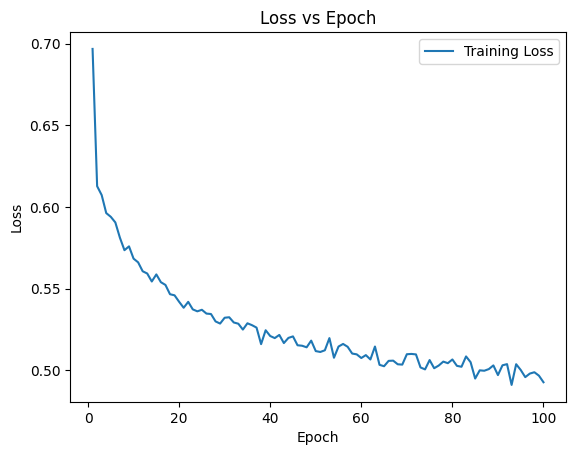

Accuracy: 73.24%


In [38]:
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
all_targets = []
all_predictions = []
all_probs = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        probs = nn.functional.softmax(output, dim=1)
        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.numpy())
        all_predictions.extend(predicted.numpy())
        all_probs.extend(probs.numpy()[:, 1])  # Get probabilities for class 1

# Calculate accuracy
accuracy = accuracy_score(all_targets, all_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

AUC: 0.7052


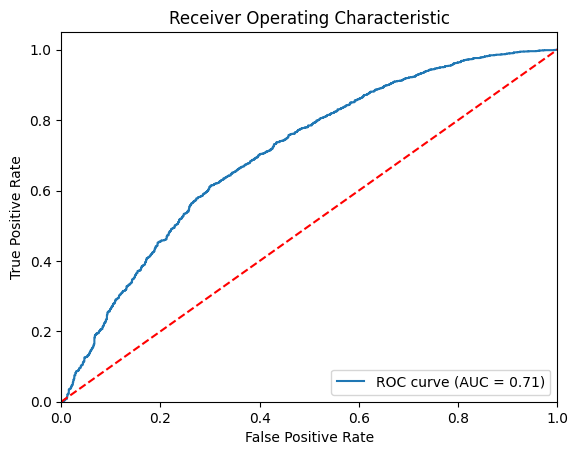

In [39]:
# Calculate AUC
auc_score = roc_auc_score(all_targets, all_probs)
print(f'AUC: {auc_score:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()